# Time series forecasting + BitPredict

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 Ti (UUID: GPU-ff183205-244d-e5aa-6214-59c049bddd64)


In [2]:
import tensorflow as tf
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2024-08-07 21:47:55.700731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 21:47:55.700794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 21:47:55.745893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 21:47:55.847320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 21:47:56.992648: W tensorflow/compiler/tf2

In [3]:
tf.__version__, keras.__version__

('2.15.1', '2.15.0')

## Prepare the data

In [4]:
!ls

LTCUSDT.csv  Main.ipynb  code/  model.png  model_experiments/


In [5]:
df = pd.read_csv("LTCUSDT.csv", parse_dates=["Date"])
df

,Unix,Date,Symbol,Open,High,Low,Close,Volume LTC,Volume USDT,tradecount
0,1719705600000,2024-06-30,LTCUSDT,74.94,75.98,74.11,75.31,317637.76400,2.383377e+07,85272
1,1719619200000,2024-06-29,LTCUSDT,72.90,76.90,72.87,74.95,348415.31500,2.609178e+07,95923
2,1719532800000,2024-06-28,LTCUSDT,73.28,74.76,72.54,72.90,412794.01800,3.038236e+07,110535
3,1719446400000,2024-06-27,LTCUSDT,71.02,73.35,70.55,73.28,300895.69100,2.160360e+07,73531
4,1719360000000,2024-06-26,LTCUSDT,71.35,71.95,70.36,71.02,286798.11800,2.044515e+07,74668
...,...,...,...,...,...,...,...,...,...,...
2387,1513468800000,2017-12-17,LTCUSDT,293.01,328.80,290.00,311.40,14682.26118,4.618547e+06,10383
2388,1513382400000,2017-12-16,LTCUSDT,294.00,305.00,285.00,293.97,9102.10005,2.674492e+06,6151
2389,1513296000000,2017-12-15,LTCUSDT,272.40,314.21,239.99,294.00,16579.78235,4.658824e+06,7826
2390,1513209600000,2017-12-14,LTCUSDT,290.01,302.72,252.00,272.40,9631.98382,2.666481e+06,5753


In [6]:
df = df.iloc[::-1]
df

,Unix,Date,Symbol,Open,High,Low,Close,Volume LTC,Volume USDT,tradecount
2391,1513123200000,2017-12-13,LTCUSDT,272.00,330.00,260.00,290.01,9565.16019,2.770877e+06,4709
2390,1513209600000,2017-12-14,LTCUSDT,290.01,302.72,252.00,272.40,9631.98382,2.666481e+06,5753
2389,1513296000000,2017-12-15,LTCUSDT,272.40,314.21,239.99,294.00,16579.78235,4.658824e+06,7826
2388,1513382400000,2017-12-16,LTCUSDT,294.00,305.00,285.00,293.97,9102.10005,2.674492e+06,6151
2387,1513468800000,2017-12-17,LTCUSDT,293.01,328.80,290.00,311.40,14682.26118,4.618547e+06,10383
...,...,...,...,...,...,...,...,...,...,...
4,1719360000000,2024-06-26,LTCUSDT,71.35,71.95,70.36,71.02,286798.11800,2.044515e+07,74668
3,1719446400000,2024-06-27,LTCUSDT,71.02,73.35,70.55,73.28,300895.69100,2.160360e+07,73531
2,1719532800000,2024-06-28,LTCUSDT,73.28,74.76,72.54,72.90,412794.01800,3.038236e+07,110535
1,1719619200000,2024-06-29,LTCUSDT,72.90,76.90,72.87,74.95,348415.31500,2.609178e+07,95923


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 2391 to 0
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unix         2392 non-null   int64         
 1   Date         2392 non-null   datetime64[ns]
 2   Symbol       2392 non-null   object        
 3   Open         2392 non-null   float64       
 4   High         2392 non-null   float64       
 5   Low          2392 non-null   float64       
 6   Close        2392 non-null   float64       
 7   Volume LTC   2392 non-null   float64       
 8   Volume USDT  2392 non-null   float64       
 9   tradecount   2392 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 187.0+ KB


In [8]:
ltc_df = pd.DataFrame(df[["Date", "Close"]])
ltc_df.head()

,Date,Close
2391,2017-12-13,290.01
2390,2017-12-14,272.40
2389,2017-12-15,294.00
2388,2017-12-16,293.97
2387,2017-12-17,311.40


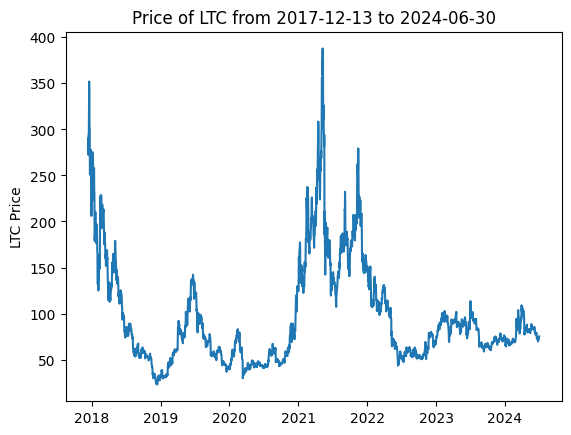

In [9]:
plt.plot(ltc_df["Date"], ltc_df["Close"])
plt.ylabel("LTC Price")
plt.title("Price of LTC from 2017-12-13 to 2024-06-30");

## Split and create datsets

In [10]:
split_size = int(0.8*len(ltc_df))

X_train, y_train = ltc_df["Date"][:split_size], ltc_df["Close"][:split_size]
X_test, y_test = ltc_df["Date"][split_size:], ltc_df["Close"][split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1913, 1913, 479, 479)

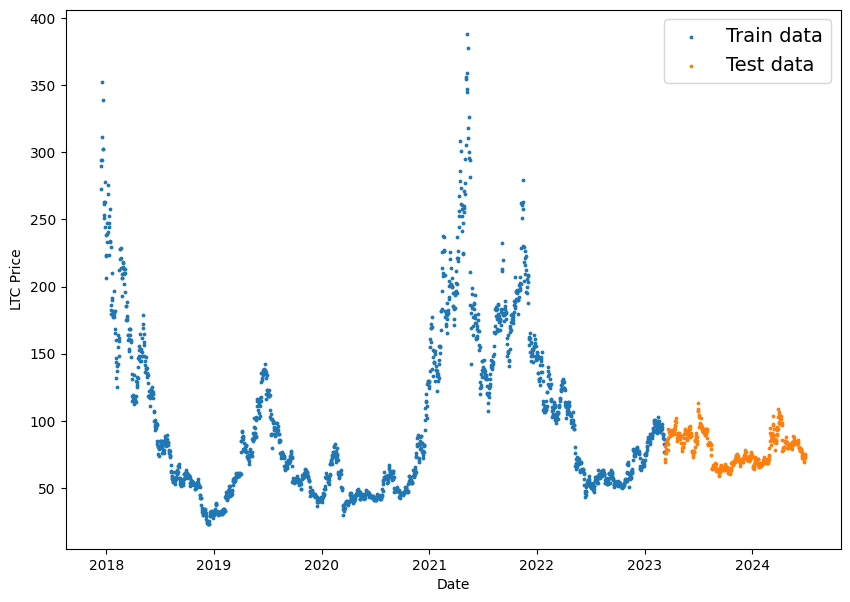

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=3, label='Train data')
plt.scatter(X_test, y_test, s=3, label='Test data')
plt.xlabel('Date')
plt.ylabel('LTC Price')
plt.legend(fontsize=14)
plt.show();

In [12]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, xlabel="Time", ylabel="Price"):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

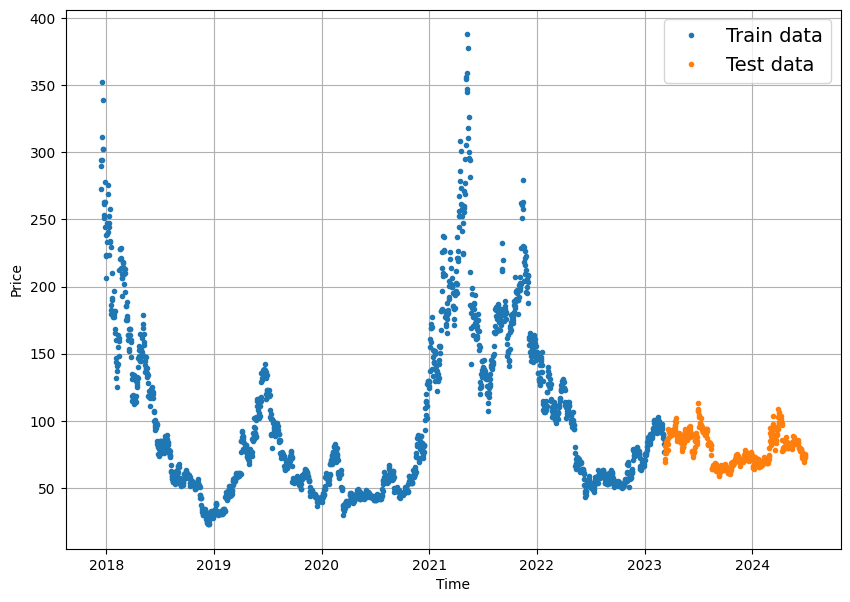

In [13]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Model0: Naive Forecast

In [14]:
naive_forecast = y_test[:-1]

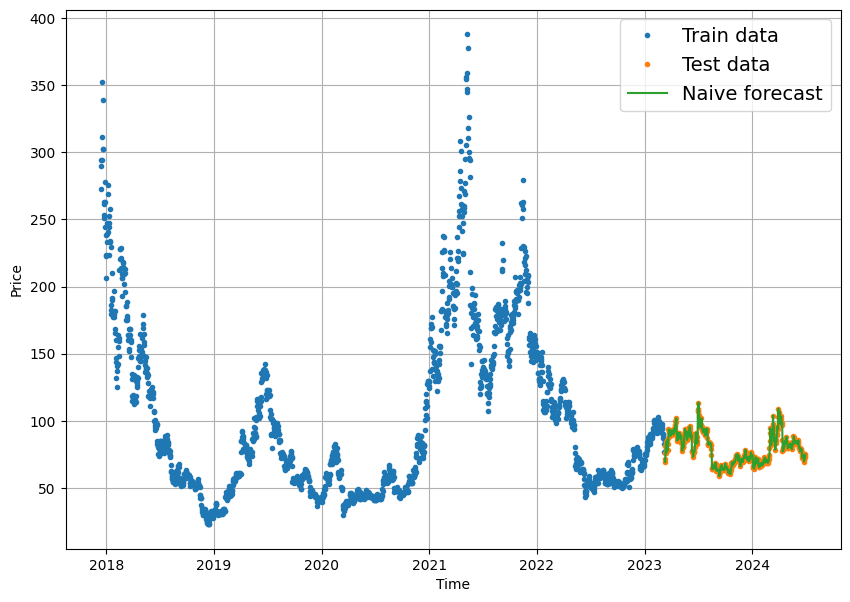

In [15]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

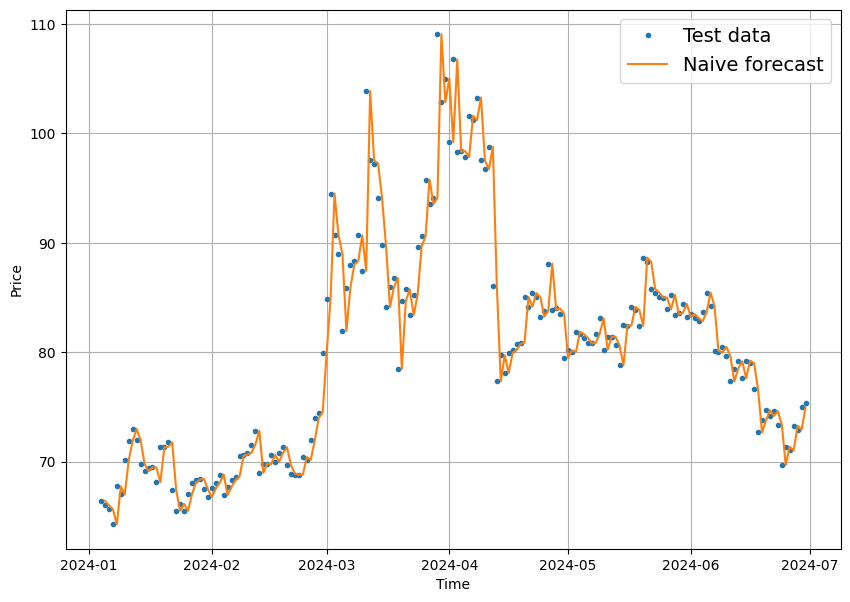

In [16]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [17]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [18]:
from keras import metrics

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }

In [19]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

2024-08-07 21:48:00.425311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 21:48:00.595875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 21:48:00.598755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

{'mae': 1.9208786,
 'mse': 9.420247,
 'rmse': 3.069242,
 'mape': 2.3441558,
 'mase': 1.000261}

In [20]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=79.42895615866388>

## Windowing dataset

In [21]:
HORIZON = 1
WINDOW  = 7

In [22]:
def get_labelled_windows(x, horizon=1):
    """
    Input: [price1, price2, price3, ... priceN] -> ([price1, price2, price3, ...], [priceN])
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [23]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
tf.squeeze(test_window).numpy(),"->", tf.squeeze(test_label).numpy()

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32), '->', 8)

In [24]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [25]:
full_windows, full_labels = make_windows(ltc_df["Close"].to_numpy())

In [26]:
full_windows.shape, full_labels.shape, len(full_windows)

((2385, 7), (2385, 1), 2385)

In [27]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [290.01 272.4  294.   293.97 311.4  352.   338.48] -> Label: [302.7]
Window: [272.4  294.   293.97 311.4  352.   338.48 302.7 ] -> Label: [302.]
Window: [294.   293.97 311.4  352.   338.48 302.7  302.  ] -> Label: [250.99]


In [28]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [29]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [30]:
for i in [train_windows, test_windows, train_labels, test_labels]:
    print(i.shape)

(1908, 7)
(477, 7)
(1908, 1)
(477, 1)


## Creating ModelCheckpoint callback

In [31]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
    return keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                          verbose=0,
                                          save_best_only=True)

## Model1: Dense model

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_windows, train_labels)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_windows, test_labels)).batch(128).prefetch(tf.data.AUTOTUNE)

In [33]:
tf.random.set_seed(42)

inputs = layers.Input((7,))
x = layers.Dense(128, activation="relu")(inputs)
outputs = layers.Dense(HORIZON, activation="linear")(x)

model_1 = keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
model_1.compile(
    optimizer="Adam",
    loss="mae",
    metrics=["mae"]
)

In [35]:
%time history_1 = model_1.fit(train_dataset, epochs=100, verbose=1,validation_data=test_dataset, callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100


2024-08-07 21:48:02.424779: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4c4d0aa0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-07 21:48:02.424804: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-08-07 21:48:02.436737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-07 21:48:02.469845: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1723056482.563774    4410 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/15 [=>............................] - ETA: 13s - loss: 223.7630 - mae: 223.7630INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 2s 46ms/step - loss: 81.5099 - mae: 81.5099 - val_loss: 29.1525 - val_mae: 29.1525
Epoch 2/100
 1/15 [=>............................] - ETA: 0s - loss: 65.2167 - mae: 65.2167INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 17ms/step - loss: 16.3330 - mae: 16.3330 - val_loss: 8.0496 - val_mae: 8.0496
Epoch 3/100
 1/15 [=>............................] - ETA: 0s - loss: 24.6351 - mae: 24.6351INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 16ms/step - loss: 8.5302 - mae: 8.5302 - val_loss: 2.8399 - val_mae: 2.8399
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 6.2465 - mae: 6.2465 - val_loss: 2.9627 - val_mae: 2.9627
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 6.1299 - mae: 6.1299 - val_loss: 3.1152 - val_mae: 3.1152
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 6.1922 - mae: 6.1922 - val_loss: 3.2475 - val_mae: 3.2475
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 5.9757 - mae: 5.9757 - val_loss: 2.9612 - val_mae: 2.9612
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 5.7614 - mae: 5.7614 - val_loss: 2.8709 - val_mae: 2.8709
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 5.6759 - mae: 5.6759 - val_loss: 2.8417 - val_mae: 2.8417
Epoch 10/100
 1/15 [=>............................] - ETA: 0s - loss: 13.1110 - mae: 13.1110IN

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 17ms/step - loss: 5.6021 - mae: 5.6021 - val_loss: 2.7913 - val_mae: 2.7913
Epoch 11/100
 1/15 [=>............................] - ETA: 0s - loss: 12.8907 - mae: 12.8907INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 16ms/step - loss: 5.5272 - mae: 5.5272 - val_loss: 2.7130 - val_mae: 2.7130
Epoch 12/100
 1/15 [=>............................] - ETA: 0s - loss: 12.6796 - mae: 12.6796INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 18ms/step - loss: 5.4385 - mae: 5.4385 - val_loss: 2.6001 - val_mae: 2.6001
Epoch 13/100
 1/15 [=>............................] - ETA: 0s - loss: 12.4485 - mae: 12.4485INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 17ms/step - loss: 5.3706 - mae: 5.3706 - val_loss: 2.5054 - val_mae: 2.5054
Epoch 14/100
 1/15 [=>............................] - ETA: 0s - loss: 12.2338 - mae: 12.2338INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 19ms/step - loss: 5.2738 - mae: 5.2738 - val_loss: 2.3602 - val_mae: 2.3602
Epoch 15/100
 1/15 [=>............................] - ETA: 0s - loss: 11.8817 - mae: 11.8817INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 17ms/step - loss: 5.1768 - mae: 5.1768 - val_loss: 2.2816 - val_mae: 2.2816
Epoch 16/100
15/15 [==============================] - 0s 2ms/step - loss: 5.0391 - mae: 5.0391 - val_loss: 2.3027 - val_mae: 2.3027
Epoch 17/100
15/15 [==============================] - 0s 2ms/step - loss: 4.9125 - mae: 4.9125 - val_loss: 2.3291 - val_mae: 2.3291
Epoch 18/100
15/15 [==============================] - 0s 2ms/step - loss: 4.8406 - mae: 4.8406 - val_loss: 2.3339 - val_mae: 2.3339
Epoch 19/100
15/15 [==============================] - 0s 2ms/step - loss: 4.7975 - mae: 4.7975 - val_loss: 2.3735 - val_mae: 2.3735
Epoch 20/100
15/15 [==============================] - 0s 2ms/step - loss: 4.7453 - mae: 4.7453 - val_loss: 2.3519 - val_mae: 2.3519
Epoch 21/100
15/15 [==============================] - 0s 2ms/step - loss: 4.7032 - mae: 4.7032 - val_loss: 2.3128 - val_mae: 2.3128
Epoch 22/100
15/15 [==============================] - 0s 2ms/step - loss: 4.6839 - mae: 

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 17ms/step - loss: 4.6193 - mae: 4.6193 - val_loss: 2.2314 - val_mae: 2.2314
Epoch 26/100
15/15 [==============================] - 0s 2ms/step - loss: 4.6116 - mae: 4.6116 - val_loss: 2.2394 - val_mae: 2.2394
Epoch 27/100
15/15 [==============================] - 0s 2ms/step - loss: 4.5868 - mae: 4.5868 - val_loss: 2.2493 - val_mae: 2.2493
Epoch 28/100
 1/15 [=>............................] - ETA: 0s - loss: 11.0172 - mae: 11.0172INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 20ms/step - loss: 4.5601 - mae: 4.5601 - val_loss: 2.2308 - val_mae: 2.2308
Epoch 29/100
 1/15 [=>............................] - ETA: 0s - loss: 10.9801 - mae: 10.9801INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 16ms/step - loss: 4.5447 - mae: 4.5447 - val_loss: 2.2119 - val_mae: 2.2119
Epoch 30/100
15/15 [==============================] - 0s 2ms/step - loss: 4.5309 - mae: 4.5309 - val_loss: 2.2189 - val_mae: 2.2189
Epoch 31/100
 1/15 [=>............................] - ETA: 0s - loss: 10.9354 - mae: 10.9354INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 16ms/step - loss: 4.5180 - mae: 4.5180 - val_loss: 2.1933 - val_mae: 2.1933
Epoch 32/100
15/15 [==============================] - 0s 2ms/step - loss: 4.4995 - mae: 4.4995 - val_loss: 2.2132 - val_mae: 2.2132
Epoch 33/100
15/15 [==============================] - 0s 2ms/step - loss: 4.4853 - mae: 4.4853 - val_loss: 2.2028 - val_mae: 2.2028
Epoch 34/100
 1/15 [=>............................] - ETA: 0s - loss: 10.8634 - mae: 10.8634INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 16ms/step - loss: 4.4753 - mae: 4.4753 - val_loss: 2.1911 - val_mae: 2.1911
Epoch 35/100
 1/15 [=>............................] - ETA: 0s - loss: 10.8406 - mae: 10.8406INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 17ms/step - loss: 4.4621 - mae: 4.4621 - val_loss: 2.1641 - val_mae: 2.1641
Epoch 36/100
15/15 [==============================] - 0s 2ms/step - loss: 4.4514 - mae: 4.4514 - val_loss: 2.1984 - val_mae: 2.1984
Epoch 37/100
15/15 [==============================] - 0s 2ms/step - loss: 4.4421 - mae: 4.4421 - val_loss: 2.1690 - val_mae: 2.1690
Epoch 38/100
15/15 [==============================] - 0s 2ms/step - loss: 4.4242 - mae: 4.4242 - val_loss: 2.2401 - val_mae: 2.2401
Epoch 39/100
15/15 [==============================] - 0s 2ms/step - loss: 4.4162 - mae: 4.4162 - val_loss: 2.1941 - val_mae: 2.1941
Epoch 40/100
15/15 [==============================] - 0s 2ms/step - loss: 4.4038 - mae: 4.4038 - val_loss: 2.2104 - val_mae: 2.2104
Epoch 41/100
15/15 [==============================] - 0s 3ms/step - loss: 4.3944 - mae: 4.3944 - val_loss: 2.2226 - val_mae: 2.2226
Epoch 42/100
15/15 [==============================] - 0s 3ms/step - loss: 4.3839 - mae: 

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 18ms/step - loss: 4.3285 - mae: 4.3285 - val_loss: 2.1490 - val_mae: 2.1490
Epoch 48/100
15/15 [==============================] - 0s 2ms/step - loss: 4.3180 - mae: 4.3180 - val_loss: 2.1645 - val_mae: 2.1645
Epoch 49/100
 1/15 [=>............................] - ETA: 0s - loss: 10.5236 - mae: 10.5236INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 20ms/step - loss: 4.3106 - mae: 4.3106 - val_loss: 2.1447 - val_mae: 2.1447
Epoch 50/100
 1/15 [=>............................] - ETA: 0s - loss: 10.4837 - mae: 10.4837INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 17ms/step - loss: 4.3022 - mae: 4.3022 - val_loss: 2.0673 - val_mae: 2.0673
Epoch 51/100
15/15 [==============================] - 0s 3ms/step - loss: 4.2945 - mae: 4.2945 - val_loss: 2.0722 - val_mae: 2.0722
Epoch 52/100
 1/15 [=>............................] - ETA: 0s - loss: 10.4022 - mae: 10.4022INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 29ms/step - loss: 4.2860 - mae: 4.2860 - val_loss: 2.0577 - val_mae: 2.0577
Epoch 53/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2783 - mae: 4.2783 - val_loss: 2.0934 - val_mae: 2.0934
Epoch 54/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2604 - mae: 4.2604 - val_loss: 2.1863 - val_mae: 2.1863
Epoch 55/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2581 - mae: 4.2581 - val_loss: 2.2107 - val_mae: 2.2107
Epoch 56/100
15/15 [==============================] - 0s 3ms/step - loss: 4.2516 - mae: 4.2516 - val_loss: 2.0879 - val_mae: 2.0879
Epoch 57/100
 1/15 [=>............................] - ETA: 0s - loss: 10.3120 - mae: 10.3120INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 18ms/step - loss: 4.2427 - mae: 4.2427 - val_loss: 2.0474 - val_mae: 2.0474
Epoch 58/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2311 - mae: 4.2311 - val_loss: 2.0973 - val_mae: 2.0973
Epoch 59/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2194 - mae: 4.2194 - val_loss: 2.1130 - val_mae: 2.1130
Epoch 60/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2146 - mae: 4.2146 - val_loss: 2.1105 - val_mae: 2.1105
Epoch 61/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2097 - mae: 4.2097 - val_loss: 2.0799 - val_mae: 2.0799
Epoch 62/100
15/15 [==============================] - 0s 2ms/step - loss: 4.2011 - mae: 4.2011 - val_loss: 2.0751 - val_mae: 2.0751
Epoch 63/100
15/15 [==============================] - 0s 2ms/step - loss: 4.1910 - mae: 4.1910 - val_loss: 2.1358 - val_mae: 2.1358
Epoch 64/100
15/15 [==============================] - 0s 2ms/step - loss: 4.1934 - mae: 

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 16ms/step - loss: 4.1098 - mae: 4.1098 - val_loss: 2.0377 - val_mae: 2.0377
Epoch 91/100
 1/15 [=>............................] - ETA: 0s - loss: 9.9567 - mae: 9.9567INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


15/15 [==============================] - 0s 15ms/step - loss: 4.0957 - mae: 4.0957 - val_loss: 2.0024 - val_mae: 2.0024
Epoch 92/100
15/15 [==============================] - 0s 2ms/step - loss: 4.0914 - mae: 4.0914 - val_loss: 2.0937 - val_mae: 2.0937
Epoch 93/100
15/15 [==============================] - 0s 2ms/step - loss: 4.1025 - mae: 4.1025 - val_loss: 2.1256 - val_mae: 2.1256
Epoch 94/100
15/15 [==============================] - 0s 2ms/step - loss: 4.1088 - mae: 4.1088 - val_loss: 2.1497 - val_mae: 2.1497
Epoch 95/100
15/15 [==============================] - 0s 2ms/step - loss: 4.1044 - mae: 4.1044 - val_loss: 2.0915 - val_mae: 2.0915
Epoch 96/100
15/15 [==============================] - 0s 2ms/step - loss: 4.0983 - mae: 4.0983 - val_loss: 2.0947 - val_mae: 2.0947
Epoch 97/100
15/15 [==============================] - 0s 2ms/step - loss: 4.0957 - mae: 4.0957 - val_loss: 2.0895 - val_mae: 2.0895
Epoch 98/100
15/15 [==============================] - 0s 2ms/step - loss: 4.0931 - mae: 

In [36]:
model_1.evaluate(test_windows, test_labels)

15/15 [==============================] - 0s 1ms/step - loss: 2.0950 - mae: 2.0950


[2.0949907302856445, 2.0949907302856445]

In [37]:
model_1 = keras.models.load_model(f"model_experiments/{model_1.name}")

In [38]:
model_1.evaluate(test_windows, test_labels)

15/15 [==============================] - 0s 1ms/step - loss: 2.0024 - mae: 2.0024


[2.002389907836914, 2.002389907836914]

In [39]:
def make_preds(model, input_data):
    try: 
        model = keras.models.load_model(f"model_experiments/{model.name}") 
    except: pass
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [40]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds

15/15 [==============================] - 0s 757us/step


<tf.Tensor: shape=(477,), dtype=float32, numpy=
array([ 69.21098 ,  74.73432 ,  79.84842 ,  83.251045,  76.95862 ,
        78.09706 ,  83.83656 ,  84.00589 ,  84.011475,  77.48643 ,
        81.75468 ,  85.846596,  92.61216 ,  93.30324 ,  91.32318 ,
        92.72598 ,  89.55744 ,  89.21029 ,  89.84358 ,  88.79755 ,
        89.11672 ,  90.8176  ,  92.32439 ,  92.76524 ,  91.76303 ,
        92.1051  ,  90.75842 ,  89.99566 ,  89.208725,  89.78394 ,
        92.538956,  93.50539 ,  92.05685 ,  93.078545,  95.23397 ,
        96.56117 ,  98.989845,  98.2228  , 101.34572 ,  91.48186 ,
        90.05789 ,  84.971756,  86.87604 ,  86.09456 ,  87.1309  ,
        89.81588 ,  87.85058 ,  89.252235,  88.66315 ,  90.705635,
        88.147125,  86.28235 ,  87.10287 ,  88.11097 ,  88.10908 ,
        87.72425 ,  83.37264 ,  83.01127 ,  77.93971 ,  79.45755 ,
        79.86053 ,  80.46022 ,  79.94681 ,  79.34551 ,  82.6746  ,
        86.0027  ,  89.37401 ,  92.94404 ,  90.72735 ,  91.6754  ,
        91.567

In [41]:
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 2.00239,
 'mse': 9.710378,
 'rmse': 3.1161478,
 'mape': 2.4424455,
 'mase': 1.0485909}

In [42]:
naive_results

{'mae': 1.9208786,
 'mse': 9.420247,
 'rmse': 3.069242,
 'mape': 2.3441558,
 'mase': 1.000261}

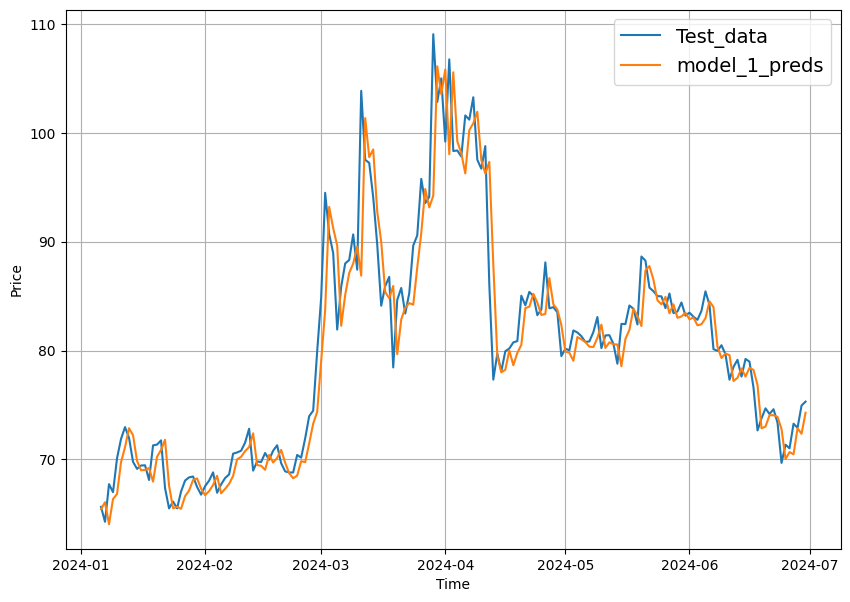

In [43]:
offset=300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format='-', label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

In [44]:
model_1.predict(tf.reshape(full_windows[1], (1, 7)))[0][0], full_labels[1][0]

1/1 [==============================] - 0s 35ms/step


(309.8832, 302.0)

In [45]:
len(test_windows)

477

## Model2: WINDOW=30 HORIZON=1

In [46]:
WINDOW_SIZE=30
full_windows, full_labels = make_windows(ltc_df.Close.to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows, full_labels

(array([[290.01, 272.4 , 294.  , ..., 244.48, 247.63, 223.77],
        [272.4 , 294.  , 293.97, ..., 247.63, 223.77, 233.11],
        [294.  , 293.97, 311.4 , ..., 223.77, 233.11, 257.98],
        ...,
        [ 83.59,  84.42,  83.21, ...,  71.35,  71.02,  73.28],
        [ 84.42,  83.21,  83.48, ...,  71.02,  73.28,  72.9 ],
        [ 83.21,  83.48,  83.11, ...,  73.28,  72.9 ,  74.95]]),
 array([[233.11],
        [257.98],
        [234.12],
        ...,
        [ 72.9 ],
        [ 74.95],
        [ 75.31]]))

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_windows, train_labels)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_windows, test_labels)).batch(128).prefetch(tf.data.AUTOTUNE)

In [48]:
tf.random.set_seed(42)

inputs = layers.Input((30,))
x = layers.Dense(128, activation="relu")(inputs)
outputs = layers.Dense(HORIZON, activation="linear")(x)

model_2 = keras.Model(inputs, outputs, name="model_2_dense")

In [49]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [51]:
model_2.fit(
    train_dataset,
    epochs=100,
    verbose=0,
    callbacks=[create_model_checkpoint(model_2.name)],
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


In [52]:
model_2_preds = make_preds(model_2, test_windows)
model_2_preds

15/15 [==============================] - 0s 805us/step


<tf.Tensor: shape=(473,), dtype=float32, numpy=
array([ 76.67089 ,  77.47345 ,  83.53243 ,  82.01457 ,  81.9694  ,
        80.20945 ,  79.639824,  83.80939 ,  88.17894 ,  92.83279 ,
        91.75896 ,  93.19556 ,  89.727844,  88.15044 ,  91.68726 ,
        88.18468 ,  89.42698 ,  89.09578 ,  89.99103 ,  90.08691 ,
        91.8081  ,  93.78211 ,  89.71514 ,  90.151886,  89.13989 ,
        90.47138 ,  93.98662 ,  91.19189 ,  90.8208  ,  92.44601 ,
        95.47874 ,  96.27078 ,  97.79499 ,  99.84616 , 100.181274,
        95.19413 ,  89.675446,  86.1828  ,  84.73297 ,  84.81013 ,
        84.721146,  88.8226  ,  87.74647 ,  87.00135 ,  89.75552 ,
        89.127716,  89.65192 ,  84.576996,  87.53227 ,  87.49995 ,
        86.53004 ,  87.03846 ,  82.90931 ,  82.801254,  77.46293 ,
        77.06706 ,  80.32476 ,  78.991714,  79.69163 ,  77.7477  ,
        81.319984,  84.18468 ,  86.5064  ,  92.14074 ,  90.13588 ,
        91.74495 ,  91.23798 ,  92.1741  ,  91.289406,  89.96978 ,
        87.340

In [53]:
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)

In [54]:
model_2_results

{'mae': 2.326897,
 'mse': 11.542919,
 'rmse': 3.3974872,
 'mape': 2.8562014,
 'mase': 1.2321707}

In [55]:
naive_results

{'mae': 1.9208786,
 'mse': 9.420247,
 'rmse': 3.069242,
 'mape': 2.3441558,
 'mase': 1.000261}

## Model 3: WINDOW_SIZE=30 HORIZON=7

In [56]:
HORIZON = 7
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(ltc_df.Close.to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)

In [57]:
model_3 = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

In [58]:
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [59]:
def compile_fit_pred(model, window_size, horizon, ltc_df=ltc_df):
    full_windows, full_labels, = make_windows(ltc_df.Close.to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
    model.compile(optimizer="Adam", loss="mae", metrics=["mae"])
    history = model.fit(train_windows, train_labels,
                           epochs=100,
                           batch_size=128,
                           verbose=0,
                           validation_data=(test_windows, test_labels),
                           callbacks=[create_model_checkpoint(model_name=model_3.name)])
    model_preds = make_preds(model, test_windows)
    model_results = evaluate_preds(tf.squeeze(test_labels), model_preds)
    return history, model_preds, model_results

In [60]:
history_3, model_3_preds, model_3_results = compile_fit_pred(model_3, 30, 7)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da953e950>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fd510>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da95fc700>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da962aad0>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


15/15 [==============================] - 0s 759us/step


In [61]:
history_3, 

(<keras.src.callbacks.History at 0x7f4da9414340>,)

In [62]:
model_3_preds

<tf.Tensor: shape=(472, 7), dtype=float32, numpy=
array([[73.33577 , 72.74156 , 72.79815 , ..., 71.12178 , 74.21227 ,
        74.629326],
       [68.62442 , 69.86752 , 68.95834 , ..., 70.76156 , 70.667046,
        71.09181 ],
       [72.23802 , 73.49269 , 71.821686, ..., 73.17612 , 71.89307 ,
        73.09047 ],
       ...,
       [74.05364 , 74.403175, 72.76849 , ..., 72.84085 , 72.76295 ,
        74.61374 ],
       [73.42055 , 74.70004 , 73.54473 , ..., 73.44257 , 72.97057 ,
        74.326225],
       [73.07008 , 73.54575 , 72.89091 , ..., 73.740105, 73.04952 ,
        73.71217 ]], dtype=float32)>

In [63]:
model_3_results

{'mae': array([ 7.062478  , 10.875251  ,  9.20489   ,  4.295566  ,  3.0698395 ,
         4.419148  ,  7.032412  ,  5.539965  ,  5.9987564 ,  7.1850443 ,
        11.053927  , 10.66719   ,  7.341725  ,  2.257793  ,  2.4731402 ,
         2.5152142 ,  2.021211  ,  2.24263   ,  4.17356   ,  4.458079  ,
         3.7537549 ,  3.0476978 ,  1.1889343 ,  0.9095971 ,  1.0642287 ,
         1.6278752 ,  1.8250101 ,  2.1519864 ,  3.5287235 ,  5.316625  ,
         5.49828   ,  3.452628  ,  4.235003  ,  4.541032  ,  4.890104  ,
         5.18612   ,  5.9960456 ,  7.6022654 ,  9.628177  , 11.926872  ,
         6.073516  ,  2.4941788 ,  3.3977606 ,  3.522983  ,  4.4563727 ,
         2.4821985 ,  0.9872491 ,  0.6892744 ,  0.9813821 ,  1.0918874 ,
         2.581507  ,  2.2217157 ,  3.3641946 ,  4.0016775 ,  4.724373  ,
         6.635798  ,  7.2600904 ,  4.478035  ,  2.4094129 ,  3.3974292 ,
         5.6075034 ,  6.0683966 ,  6.6995425 ,  8.242827  , 10.401182  ,
         9.829005  ,  7.080406  ,  3.9572144

In [64]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    if mae.ndim > 0:
        mae  = tf.reduce_mean(mae)
        mse  = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    
    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }

In [65]:
history_3, model_3_preds, model_3_results = compile_fit_pred(model_3, 30, 7)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046cb50>, 139970043052720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ece0>, 139970043290256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d5046ebc0>, 139971531823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4da9c03c10>, 139971531830128), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


15/15 [==============================] - 0s 736us/step


In [66]:
model_3_results

{'mae': 3.830413,
 'mse': 32.120148,
 'rmse': 4.405251,
 'mape': 4.676385,
 'mase': 2.0119793}

In [67]:
# offset = 300
# plt.figure(figsize=(10, 7))
# # Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
# plot_time_series(timesteps=X_test[-len(test_windows):], 
#                  values=tf.squeeze(test_labels), 
#                  start=offset, 
#                  label="Test_data")
# plot_time_series(timesteps=(X_test[-len(test_windows):])[:len(X_test[-len(test_windows):])], 
#                  values=tf.reduce_mean(model_3_preds, axis=1), 
#                  format="-",
#                  start=offset, 
#                  label="model_3_preds")

In [68]:
model_3_preds

<tf.Tensor: shape=(472, 7), dtype=float32, numpy=
array([[71.75687 , 72.187836, 72.939384, ..., 71.61867 , 72.68713 ,
        72.036995],
       [68.15612 , 69.70708 , 70.11228 , ..., 70.86837 , 70.23609 ,
        69.27725 ],
       [72.82766 , 74.82243 , 73.9938  , ..., 74.763596, 73.776115,
        72.970345],
       ...,
       [73.21212 , 74.11257 , 73.410515, ..., 73.64635 , 72.95075 ,
        72.993515],
       [73.06295 , 74.517   , 74.50625 , ..., 74.19206 , 73.469055,
        73.07941 ],
       [72.283775, 73.603226, 73.685455, ..., 73.82883 , 72.8012  ,
        72.305275]], dtype=float32)>

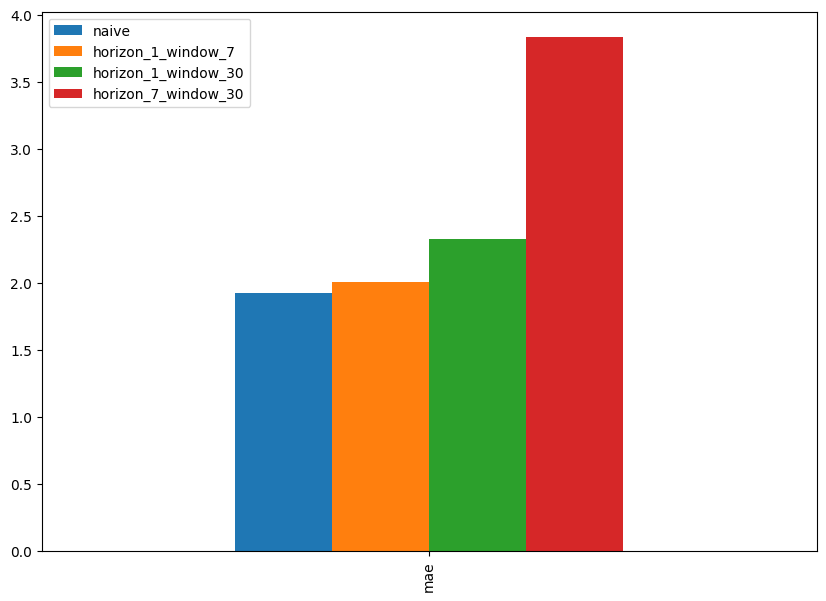

In [69]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");


## CONV1D

In [70]:
HORIZON, WINDOW_SIZE = 1, 7

In [71]:
prices = ltc_df.Close.to_numpy()

In [72]:
full_windows, full_labels = make_windows(prices)
full_windows.shape, full_labels.shape

((2385, 7), (2385, 1))

In [73]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [74]:
[i.shape for i in [train_windows, test_windows, train_labels, test_labels]]

[(1908, 7), (477, 7), (1908, 1), (477, 1)]

In [75]:
train_windows[0].shape

(7,)

In [76]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
x.shape, expand_dims_layer(x).shape, expand_dims_layer(x)

(TensorShape([7]),
 TensorShape([7, 1]),
 <tf.Tensor: shape=(7, 1), dtype=float32, numpy=
 array([[290.01],
        [272.4 ],
        [294.  ],
        [293.97],
        [311.4 ],
        [352.  ],
        [338.48]], dtype=float32)>)

In [77]:
model_4 = keras.Sequential([
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_4_CONV1D")

In [78]:
model_4.compile(loss="mae",
               optimizer="Adam")

In [79]:
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

2024-08-07 21:48:35.566178: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9c550>, 139970043647104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9ddb0>, 139971528761120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f3a0>, 139971528769200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4daae9f220>, 139971528753680), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_CONV1D/assets


In [80]:
model_4.summary()


Model: "model_4_CONV1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
model_4_preds = make_preds(model_4, test_windows)

15/15 [==============================] - 0s 5ms/step


In [82]:
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 1.9136211,
 'mse': 9.443471,
 'rmse': 3.073023,
 'mape': 2.341041,
 'mase': 1.0021054}

## LSTM model

In [83]:
inputs = layers.Input(shape=(WINDOW_SIZE))
expand_dims = expand_dims_layer(inputs)
x = layers.LSTM(128, activation="relu")(expand_dims)
outputs = layers.Dense(HORIZON, activation="linear")(x)

model_5 = keras.Model(inputs, outputs, name="model_5_LSTM")

In [84]:
model_5.compile(loss="mae", optimizer="Adam")

In [85]:
history_5 = model_5.fit(
    train_windows, train_labels,
    batch_size=128,
    epochs=100,
    verbose=1,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_5.name)]
)

Epoch 1/100
 1/15 [=>............................] - ETA: 16s - loss: 89.8108INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 2s 66ms/step - loss: 74.1102 - val_loss: 37.7472
Epoch 2/100
 1/15 [=>............................] - ETA: 0s - loss: 48.6835INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 21.1557 - val_loss: 7.6771
Epoch 3/100
 1/15 [=>............................] - ETA: 0s - loss: 11.2756INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 7.9554 - val_loss: 4.2093
Epoch 4/100
 1/15 [=>............................] - ETA: 0s - loss: 9.7985INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 6.8188 - val_loss: 3.1008
Epoch 5/100
 1/15 [=>............................] - ETA: 0s - loss: 5.7667INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 68ms/step - loss: 6.6547 - val_loss: 3.0003
Epoch 6/100
 1/15 [=>............................] - ETA: 0s - loss: 6.9811INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 6.5096 - val_loss: 2.8495
Epoch 7/100
 1/15 [=>............................] - ETA: 0s - loss: 5.0289INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 6.0838 - val_loss: 2.6621
Epoch 8/100
 1/15 [=>............................] - ETA: 0s - loss: 5.4260INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 5.5120 - val_loss: 2.2894
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 5.0216 - val_loss: 2.3249
Epoch 10/100
 1/15 [=>............................] - ETA: 0s - loss: 5.0124INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 69ms/step - loss: 4.8399 - val_loss: 2.2872
Epoch 11/100
 1/15 [=>............................] - ETA: 0s - loss: 4.8715INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 58ms/step - loss: 4.7427 - val_loss: 2.2817
Epoch 12/100
15/15 [==============================] - 0s 4ms/step - loss: 4.7546 - val_loss: 2.4116
Epoch 13/100
15/15 [==============================] - 0s 4ms/step - loss: 4.7110 - val_loss: 2.3504
Epoch 14/100
15/15 [==============================] - 0s 4ms/step - loss: 4.8591 - val_loss: 2.4757
Epoch 15/100
 1/15 [=>............................] - ETA: 0s - loss: 5.5228INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 4.9213 - val_loss: 2.2121
Epoch 16/100
 1/15 [=>............................] - ETA: 0s - loss: 5.2614INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 4.6897 - val_loss: 2.2100
Epoch 17/100
 1/15 [=>............................] - ETA: 0s - loss: 4.8334INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 4.6424 - val_loss: 2.1490
Epoch 18/100
15/15 [==============================] - 0s 4ms/step - loss: 4.6824 - val_loss: 2.2237
Epoch 19/100
15/15 [==============================] - 0s 4ms/step - loss: 4.6336 - val_loss: 2.1753
Epoch 20/100
 1/15 [=>............................] - ETA: 0s - loss: 3.9869INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 70ms/step - loss: 4.6398 - val_loss: 2.1353
Epoch 21/100
15/15 [==============================] - 0s 4ms/step - loss: 4.5523 - val_loss: 2.2425
Epoch 22/100
 1/15 [=>............................] - ETA: 0s - loss: 4.3008INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 4.6350 - val_loss: 2.1222
Epoch 23/100
15/15 [==============================] - 0s 4ms/step - loss: 4.7204 - val_loss: 2.1300
Epoch 24/100
 1/15 [=>............................] - ETA: 0s - loss: 3.6623INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 4.7038 - val_loss: 2.0890
Epoch 25/100
15/15 [==============================] - 0s 4ms/step - loss: 4.6365 - val_loss: 2.3303
Epoch 26/100
15/15 [==============================] - 0s 4ms/step - loss: 4.4864 - val_loss: 2.2654
Epoch 27/100
15/15 [==============================] - 0s 4ms/step - loss: 4.5493 - val_loss: 2.4451
Epoch 28/100
 1/15 [=>............................] - ETA: 0s - loss: 4.8248INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 4.4576 - val_loss: 2.0663
Epoch 29/100
15/15 [==============================] - 0s 4ms/step - loss: 4.4575 - val_loss: 2.0902
Epoch 30/100
15/15 [==============================] - 0s 4ms/step - loss: 4.4952 - val_loss: 2.1262
Epoch 31/100
15/15 [==============================] - 0s 4ms/step - loss: 4.5373 - val_loss: 2.2663
Epoch 32/100
15/15 [==============================] - 0s 4ms/step - loss: 4.4661 - val_loss: 2.0913
Epoch 33/100
 1/15 [=>............................] - ETA: 0s - loss: 3.9255INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 4.5124 - val_loss: 2.0484
Epoch 34/100
15/15 [==============================] - 0s 4ms/step - loss: 4.4425 - val_loss: 2.0599
Epoch 35/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3878 - val_loss: 2.1079
Epoch 36/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3899 - val_loss: 2.0609
Epoch 37/100
15/15 [==============================] - 0s 4ms/step - loss: 4.4077 - val_loss: 2.2009
Epoch 38/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3636 - val_loss: 2.0777
Epoch 39/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3330 - val_loss: 2.0823
Epoch 40/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3846 - val_loss: 2.1450
Epoch 41/100
15/15 [==============================] - 0s 4ms/step - loss: 4.5031 - val_loss: 2.2376
Epoch 42/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3738 - val_loss: 2.1703
Epoch 43/100

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 69ms/step - loss: 4.3273 - val_loss: 2.0178
Epoch 45/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3132 - val_loss: 2.0703
Epoch 46/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2865 - val_loss: 2.0283
Epoch 47/100
 1/15 [=>............................] - ETA: 0s - loss: 4.1188INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 4.2739 - val_loss: 2.0060
Epoch 48/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3089 - val_loss: 2.2278
Epoch 49/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3868 - val_loss: 2.0071
Epoch 50/100
 1/15 [=>............................] - ETA: 0s - loss: 5.2496INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 58ms/step - loss: 4.3016 - val_loss: 2.0013
Epoch 51/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3082 - val_loss: 2.0204
Epoch 52/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2643 - val_loss: 2.0430
Epoch 53/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2701 - val_loss: 2.0410
Epoch 54/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2440 - val_loss: 2.2899
Epoch 55/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2731 - val_loss: 2.0734
Epoch 56/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2497 - val_loss: 2.1825
Epoch 57/100
 1/15 [=>............................] - ETA: 0s - loss: 3.8803INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 4.2531 - val_loss: 1.9530
Epoch 58/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2850 - val_loss: 1.9908
Epoch 59/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2793 - val_loss: 2.1612
Epoch 60/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2049 - val_loss: 2.0463
Epoch 61/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2449 - val_loss: 2.2383
Epoch 62/100
 1/15 [=>............................] - ETA: 0s - loss: 4.1685INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 56ms/step - loss: 4.2085 - val_loss: 1.9467
Epoch 63/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2252 - val_loss: 2.0526
Epoch 64/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1729 - val_loss: 1.9573
Epoch 65/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2081 - val_loss: 1.9620
Epoch 66/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2096 - val_loss: 2.4139
Epoch 67/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2139 - val_loss: 2.3813
Epoch 68/100
 1/15 [=>............................] - ETA: 0s - loss: 4.3398INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 71ms/step - loss: 4.2081 - val_loss: 1.9223
Epoch 69/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1933 - val_loss: 2.2149
Epoch 70/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1792 - val_loss: 2.1206
Epoch 71/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2023 - val_loss: 2.1448
Epoch 72/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1256 - val_loss: 2.0828
Epoch 73/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1417 - val_loss: 1.9794
Epoch 74/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3289 - val_loss: 1.9584
Epoch 75/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2162 - val_loss: 2.0392
Epoch 76/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1087 - val_loss: 2.0464
Epoch 77/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1767 - val_loss: 2.0142
Epoch 78/100

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


15/15 [==============================] - 1s 57ms/step - loss: 4.0887 - val_loss: 1.9111
Epoch 89/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2449 - val_loss: 2.1826
Epoch 90/100
15/15 [==============================] - 0s 4ms/step - loss: 4.2859 - val_loss: 2.2083
Epoch 91/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1436 - val_loss: 2.2223
Epoch 92/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1274 - val_loss: 1.9958
Epoch 93/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1424 - val_loss: 2.0998
Epoch 94/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1497 - val_loss: 2.1707
Epoch 95/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1700 - val_loss: 2.1233
Epoch 96/100
15/15 [==============================] - 0s 4ms/step - loss: 4.3513 - val_loss: 1.9198
Epoch 97/100
15/15 [==============================] - 0s 4ms/step - loss: 4.1489 - val_loss: 1.9929
Epoch 98/100

In [86]:
model_5_preds = make_preds(model_5, test_windows)

15/15 [==============================] - 0s 1ms/step


In [87]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 1.9111456,
 'mse': 9.470893,
 'rmse': 3.0774815,
 'mape': 2.3324375,
 'mase': 1.000809}

In [88]:
naive_results

{'mae': 1.9208786,
 'mse': 9.420247,
 'rmse': 3.069242,
 'mape': 2.3441558,
 'mase': 1.000261}

## Adding Block reward

In [89]:
block_rewards = [50, 25, 12.5, 6.25]
block_reward_datatimes = [
    np.datetime64("2015-08-25"),
    np.datetime64("2019-08-05"),
    np.datetime64("2023-08-02")
] # first skip
block_reward_datatimes

[numpy.datetime64('2015-08-25'),
 numpy.datetime64('2019-08-05'),
 numpy.datetime64('2023-08-02')]

In [90]:
ltc_prices = pd.DataFrame({"Date": df.Date, "Close": df.Close}).set_index("Date")
ltc_prices.head()

,Close
Date,
2017-12-13,290.01
2017-12-14,272.40
2017-12-15,294.00
2017-12-16,293.97
2017-12-17,311.40


In [91]:
block_reward_2_days = (block_reward_datatimes[1] - ltc_prices.index[0]).days
block_reward_3_days = (block_reward_datatimes[2] - ltc_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(600, 2058)

In [92]:
# Add block_reward column
ltc_prices_block = ltc_prices.copy()
ltc_prices_block["Block"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
ltc_prices_block.iloc[:block_reward_2_days, -1] = block_rewards[1]
ltc_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_rewards[2]
ltc_prices_block.iloc[block_reward_3_days:, -1] = block_rewards[3]
ltc_prices_block.head()

,Close,Block
Date,,
2017-12-13,290.01,25
2017-12-14,272.40,25
2017-12-15,294.00,25
2017-12-16,293.97,25
2017-12-17,311.40,25


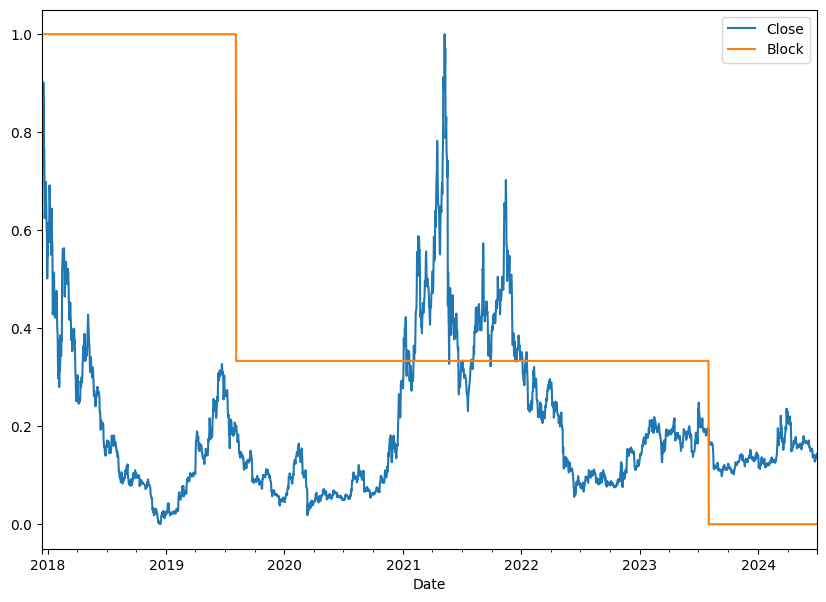

In [93]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(ltc_prices_block[["Close", "Block"]]),
                                   columns=ltc_prices_block.columns,
                                   index=ltc_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

In [94]:
ltc_prices_window = ltc_prices_block.copy()

for i in range(WINDOW_SIZE):
    ltc_prices_window[f"Price+{i+1}"] = ltc_prices_window["Close"].shift(periods=i+1)
ltc_prices_window

,Close,Block,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2017-12-13,290.01,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-14,272.40,25,290.01,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-15,294.00,25,272.40,290.01,NaN,NaN,NaN,NaN,NaN
2017-12-16,293.97,25,294.00,272.40,290.01,NaN,NaN,NaN,NaN
2017-12-17,311.40,25,293.97,294.00,272.40,290.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-06-26,71.02,6.25,71.35,69.68,73.37,74.61,74.17,74.69,73.77
2024-06-27,73.28,6.25,71.02,71.35,69.68,73.37,74.61,74.17,74.69
2024-06-28,72.90,6.25,73.28,71.02,71.35,69.68,73.37,74.61,74.17


In [95]:
X = ltc_prices_window.dropna().drop("Close", axis=1).astype(np.float32)
y = ltc_prices_window.dropna()["Close"].astype(np.float32).rename({"Close": "Price"})
X

,Block,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2017-12-20,25.00,338.480011,352.000000,311.399994,293.970001,294.000000,272.399994,290.010010
2017-12-21,25.00,302.700012,338.480011,352.000000,311.399994,293.970001,294.000000,272.399994
2017-12-22,25.00,302.000000,302.700012,338.480011,352.000000,311.399994,293.970001,294.000000
2017-12-23,25.00,250.990005,302.000000,302.700012,338.480011,352.000000,311.399994,293.970001
2017-12-24,25.00,253.440002,250.990005,302.000000,302.700012,338.480011,352.000000,311.399994
...,...,...,...,...,...,...,...,...
2024-06-26,6.25,71.349998,69.680000,73.370003,74.610001,74.169998,74.690002,73.769997
2024-06-27,6.25,71.019997,71.349998,69.680000,73.370003,74.610001,74.169998,74.690002
2024-06-28,6.25,73.279999,71.019997,71.349998,69.680000,73.370003,74.610001,74.169998


In [96]:
y

Date
2017-12-20    302.700012
2017-12-21    302.000000
2017-12-22    250.990005
2017-12-23    253.440002
2017-12-24    262.899994
                 ...    
2024-06-26     71.019997
2024-06-27     73.279999
2024-06-28     72.900002
2024-06-29     74.949997
2024-06-30     75.309998
Name: Close, Length: 2385, dtype: float32

In [97]:
split_size = int(len(X)*0.8)
X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test = y[:split_size], y[split_size:]
X_train, y_train

(            Block     Price+1     Price+2     Price+3     Price+4     Price+5  \
 Date                                                                            
 2017-12-20   25.0  338.480011  352.000000  311.399994  293.970001  294.000000   
 2017-12-21   25.0  302.700012  338.480011  352.000000  311.399994  293.970001   
 2017-12-22   25.0  302.000000  302.700012  338.480011  352.000000  311.399994   
 2017-12-23   25.0  250.990005  302.000000  302.700012  338.480011  352.000000   
 2017-12-24   25.0  253.440002  250.990005  302.000000  302.700012  338.480011   
 ...           ...         ...         ...         ...         ...         ...   
 2023-03-07   12.5   87.360001   89.930000   89.339996   90.559998   95.389999   
 2023-03-08   12.5   86.290001   87.360001   89.930000   89.339996   90.559998   
 2023-03-09   12.5   82.760002   86.290001   87.360001   89.930000   89.339996   
 2023-03-10   12.5   76.680000   82.760002   86.290001   87.360001   89.930000   
 2023-03-11   12

In [98]:
week_inputs = layers.Input((7,))
week_outputs = layers.Dense(64, activation="relu")(week_inputs)
week_model = tf.keras.Model(week_inputs, week_outputs)

block_inputs = layers.Input((1,))
block_outputs = layers.Dense(64, activation="relu")(block_inputs)
block_model = tf.keras.Model(block_inputs, block_outputs)

combined = layers.Concatenate()([week_model.output, block_model.output])
output = layers.Dense(HORIZON, activation="linear")(combined)
model_6 = tf.keras.Model([week_model.input, block_model.inputs], output, name="model_6_dense")

In [99]:
model_6.summary()

Model: "model_6_dense"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 64)                   512       ['input_4[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 64)                   128       ['input_5[0][0]']             
                                                                                      

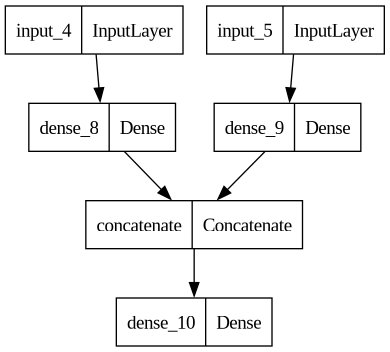

In [100]:
tf.keras.utils.plot_model(model_6)

In [101]:
model_6.compile(loss="mae", optimizer="Adam")

In [102]:
X_train_block = X_train.Block
X_train_week = X_train.drop(["Block"], axis=1)

X_test_block = X_test.Block
X_test_week = X_test.drop(["Block"], axis=1)

In [103]:
history_6 = model_6.fit(
    (X_train_week, X_train_block),
    y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=((X_test_week, X_test_block), y_test),
    callbacks=[create_model_checkpoint(model_6.name)]
)

INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense/assets


In [104]:
model_6_preds = make_preds(model_6, (X_test_week, X_test_block))

15/15 [==============================] - 0s 817us/step


In [105]:
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 1.9272951,
 'mse': 9.562774,
 'rmse': 3.0923734,
 'mape': 2.353808,
 'mase': 1.009266}

In [106]:
model_5_results, naive_results

({'mae': 1.9111456,
  'mse': 9.470893,
  'rmse': 3.0774815,
  'mape': 2.3324375,
  'mase': 1.000809},
 {'mae': 1.9208786,
  'mse': 9.420247,
  'rmse': 3.069242,
  'mape': 2.3441558,
  'mase': 1.000261})

WE BEAT THE BASELINE!!!

## Model 7: Model 6 + 128 hidden units

In [107]:
week_inputs = layers.Input((7,))
x = layers.Dense(64, activation="relu")(week_inputs)
week_outputs = layers.Dense(64, activation="relu")(x)
week_model = tf.keras.Model(week_inputs, week_outputs)

block_inputs = layers.Input((1,))
x = layers.Dense(64, activation="relu")(block_inputs)
block_outputs = layers.Dense(64, activation="relu")(x)
block_model = tf.keras.Model(block_inputs, block_outputs)

combined = layers.Concatenate()([week_model.output, block_model.output])
output = layers.Dense(HORIZON, activation="linear")(combined)
model_6_1 = tf.keras.Model([week_model.input, block_model.inputs], output, name="model_6_1_dense")

In [108]:
model_6_1.compile(loss="mae", optimizer="Adam")

In [109]:
history_6_1 = model_6_1.fit(
    (X_train_week, X_train_block),
    y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=((X_test_week, X_test_block), y_test),
    callbacks=[create_model_checkpoint(model_6_1.name)]
)

INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_1_dense/assets


In [110]:
model_6_1_preds = make_preds(model_6_1, (X_test_week, X_test_block))

15/15 [==============================] - 0s 950us/step


In [111]:
model_6_1_results = evaluate_preds(y_test, model_6_1_preds)
model_6_1_results

{'mae': 1.9305235,
 'mse': 9.505301,
 'rmse': 3.083067,
 'mape': 2.3559487,
 'mase': 1.0109566}

In [112]:
naive_results

{'mae': 1.9208786,
 'mse': 9.420247,
 'rmse': 3.069242,
 'mape': 2.3441558,
 'mase': 1.000261}

In [113]:
model_6_results

{'mae': 1.9272951,
 'mse': 9.562774,
 'rmse': 3.0923734,
 'mape': 2.353808,
 'mase': 1.009266}

:(

## Model 7: N-BEATS algo (rithm)

In [114]:
import keras
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                input_size: int,
                theta_size: int,
                neurons: int,
                layers: int,
                horizon=1, 
                **kwargs):
        super().__init__(**kwargs)
        
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.neurons = neurons
        self.layers = layers

        self.hidden = [keras.layers.Dense(self.neurons, activation="relu") for _ in range(layers)]
        self.theta_layer = keras.layers.Dense(theta_size)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [115]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       neurons=128,
                                       layers=4,)

In [116]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [117]:
tf.random.set_seed(42)
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 1.0829813  -0.6842052  -0.10953214  0.25735325 -0.41814542 -0.17442165
 -0.10257059]
Forecast: 0.42580747604370117


### Preparing data

In [118]:
X_nbeats = X.drop("Block", axis=1)
X_nbeats, y

(               Price+1     Price+2     Price+3     Price+4     Price+5  \
 Date                                                                     
 2017-12-20  338.480011  352.000000  311.399994  293.970001  294.000000   
 2017-12-21  302.700012  338.480011  352.000000  311.399994  293.970001   
 2017-12-22  302.000000  302.700012  338.480011  352.000000  311.399994   
 2017-12-23  250.990005  302.000000  302.700012  338.480011  352.000000   
 2017-12-24  253.440002  250.990005  302.000000  302.700012  338.480011   
 ...                ...         ...         ...         ...         ...   
 2024-06-26   71.349998   69.680000   73.370003   74.610001   74.169998   
 2024-06-27   71.019997   71.349998   69.680000   73.370003   74.610001   
 2024-06-28   73.279999   71.019997   71.349998   69.680000   73.370003   
 2024-06-29   72.900002   73.279999   71.019997   71.349998   69.680000   
 2024-06-30   74.949997   72.900002   73.279999   71.019997   71.349998   
 
                Price+6

In [119]:
split_size = int(len(X) * 0.8)
X_nbeats_train, y_train = X_nbeats[:split_size], y[:split_size]
X_nbeats_test, y_test = X_nbeats[split_size:], y[split_size:]
X_nbeats_train.shape, y_train.shape, X_nbeats_test.shape, y_test.shape

((1908, 7), (1908,), (477, 7), (477,))

In [120]:
BATCH_SIZE=1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_nbeats_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_nbeats_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [121]:
EPOCHS = 5000
NEURONS = 512
LAYERS = 4
STACKS=50
WINDOW_SIZE = 7
HORIZON = 1
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [122]:
layers.subtract([tf.constant([1, 2, 3]), tf.constant([1, 3, 5])]), \
    layers.add([tf.constant([1, 2, 3]), tf.constant([1, 3, 5])])

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 0, -1, -2], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 5, 8], dtype=int32)>)

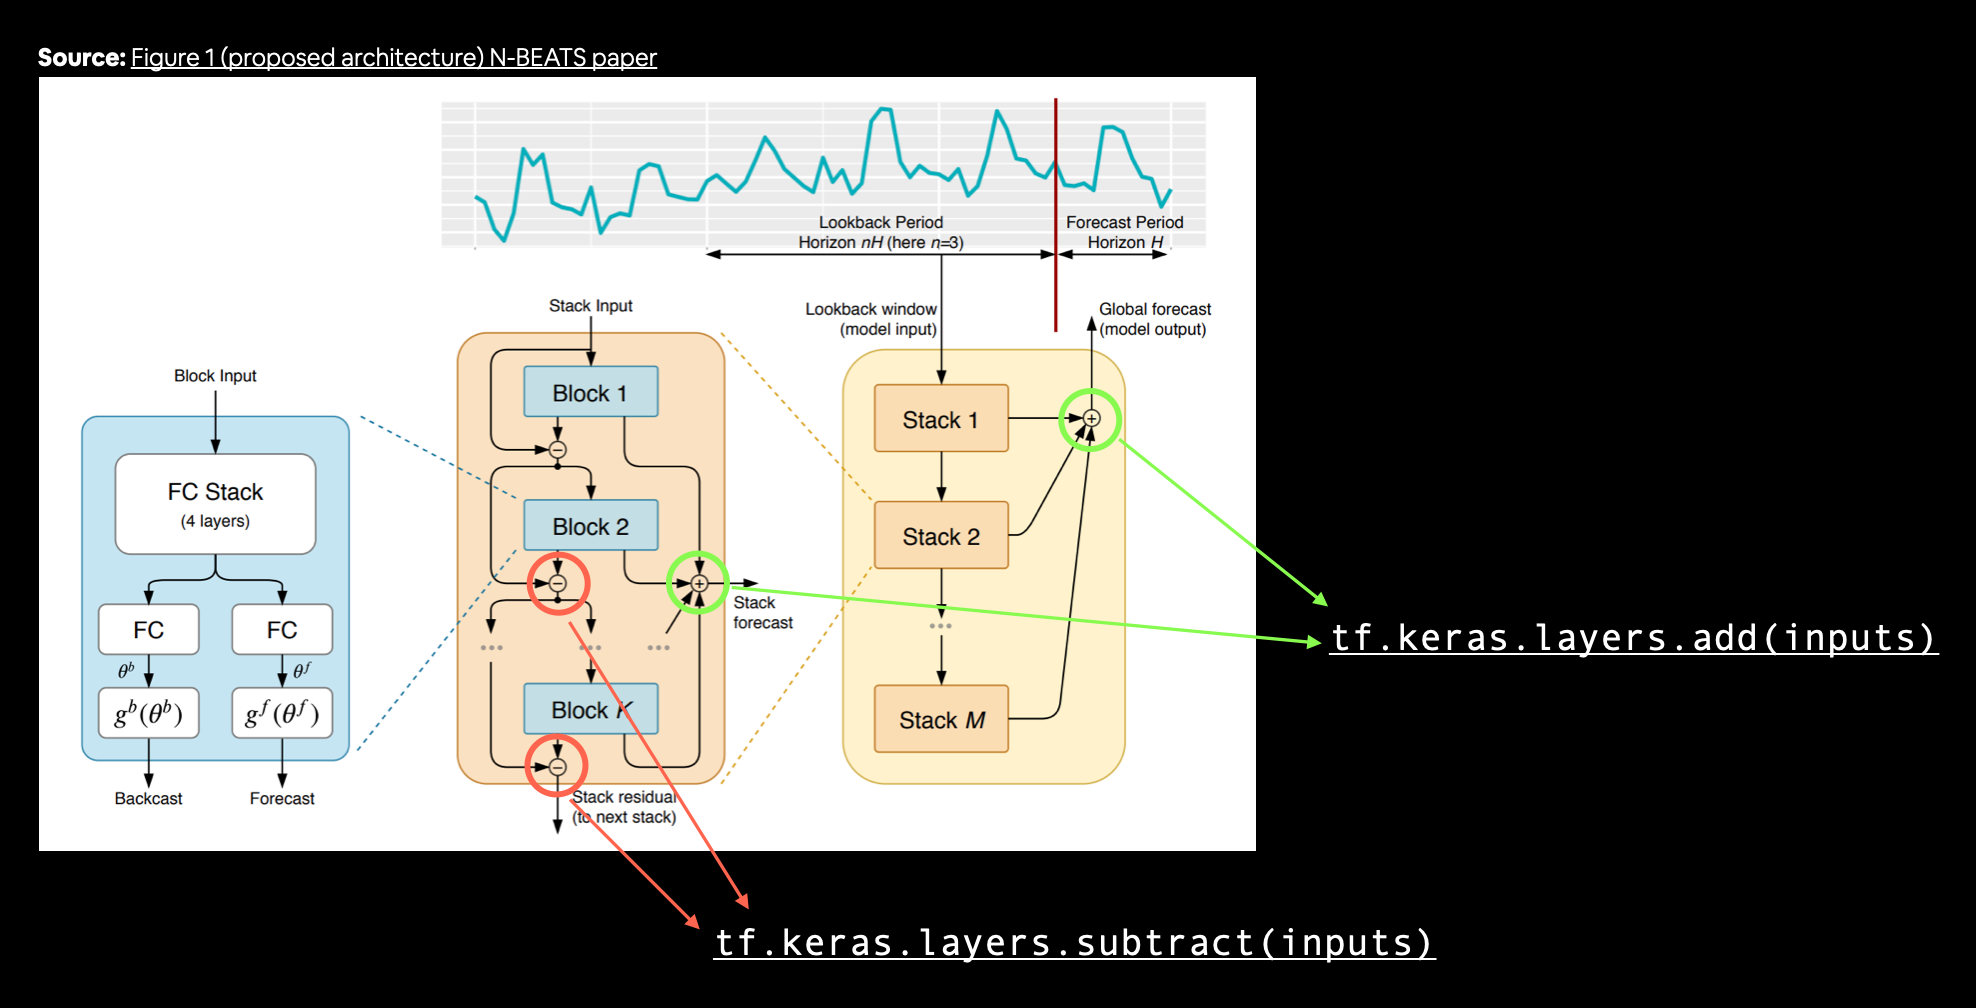

In [123]:
%%time 

tf.random.set_seed(42)

# 1.
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                theta_size=THETA_SIZE,
                                horizon=HORIZON,
                                neurons=NEURONS,
                                layers=LAYERS,
                                name="InitialBlock")

# 2.
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. 
residuals, forecast = nbeats_block_layer(stack_input)

# 4.
for i, _ in enumerate(range(STACKS - 1)): # first stack is already created so -1
    # 5.
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        neurons=NEURONS,
        layers=LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) # <--

    # 6.
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7.
model_7 = tf.keras.Model(stack_input, forecast, name="NBEATS")

# 8.
model_7.compile(optimizer="Adam", loss="mae")

# 9.
history_7 = model_7.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=200,
                                               restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(patience=100,
                                                  verbose=1)]
)


Epoch 286: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 386: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 17s, sys: 15.3 s, total: 2min 32s
Wall time: 3min 13s


In [124]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([70.20291 , 75.27665 , 80.288864, 83.32791 , 77.62264 , 78.75987 ,
       84.989525, 83.92838 , 84.30524 , 78.89926 ], dtype=float32)>

In [125]:
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

{'mae': 1.925089,
 'mse': 9.558372,
 'rmse': 3.0916617,
 'mape': 2.3538587,
 'mase': 1.0081108}

In [126]:
naive_results, model_1_results

({'mae': 1.9208786,
  'mse': 9.420247,
  'rmse': 3.069242,
  'mape': 2.3441558,
  'mase': 1.000261},
 {'mae': 2.00239,
  'mse': 9.710378,
  'rmse': 3.1161478,
  'mape': 2.4424455,
  'mase': 1.0485909})

## Model 8: Creating an ensemble

It combines many *different* models to predict a common goal.

### Constructing and fitting ensemble of models

In [127]:
def get_ensemble_models(horizon=HORIZON,
                       train_data=train_dataset,
                       test_data=test_dataset,
                       num_iter=10,
                       epochs=1000,
                       loss_fns=["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE, MAPE losses.

    Example: num_iter = 10 -> int(10 * len(loss_fn)) models will be returned.
    """
    ensemble_models = []

    for i in range(num_iter):
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {epochs}, model_number: {i}")

            # Simple model
            model = keras.Sequential([
                layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
                layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
                layers.Dense(HORIZON)
            ])
            # Compile & fit
            model.compile(
                optimizer=keras.optimizers.Adam(),
                loss=loss_function,
                metrics=["mae", "mse"])
            model.fit(
                train_data,
                epochs=epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[keras.callbacks.EarlyStopping(patience=200,restore_best_weights=True),
                           keras.callbacks.ReduceLROnPlateau(patience=100, verbose=1)])
            ensemble_models.append(model)
    return ensemble_models

In [128]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5)

Optimizing model by reducing: mae for 1000, model_number: 0

Epoch 499: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 599: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000, model_number: 0

Epoch 157: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 257: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000, model_number: 0

Epoch 278: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 378: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000, model_number: 1

Epoch 182: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 304: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 404: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1

In [129]:
ensemble_models

### Make preds with our ensemble model

In [130]:
def make_ensemble_preds(ensemble_models, data):
    """
    Returns a list of predictions
    """
    return tf.squeeze(tf.constant([model.predict(data) for model in ensemble_models]))

In [131]:
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds.shape

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
CPU times: user 407 ms, sys: 29.8 ms, total: 437 ms
Wall time: 410 ms


TensorShape([15, 477])

In [132]:
ensemble_results = evaluate_preds(y_test, ensemble_preds)
ensemble_results

{'mae': 1.9368619,
 'mse': 9.5469885,
 'rmse': 3.089683,
 'mape': 2.363968,
 'mase': 1.0142759}

In [133]:
model_1_results

{'mae': 2.00239,
 'mse': 9.710378,
 'rmse': 3.1161478,
 'mape': 2.4424455,
 'mase': 1.0485909}

In [134]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean

<tf.Tensor: shape=(477,), dtype=float32, numpy=
array([ 69.65351 ,  75.428665,  80.77922 ,  83.06255 ,  76.6801  ,
        78.69087 ,  85.88381 ,  83.4642  ,  83.888916,  78.265335,
        82.22313 ,  87.496086,  92.92366 ,  93.56082 ,  91.27099 ,
        93.81005 ,  89.917076,  89.05417 ,  91.22176 ,  89.03797 ,
        89.51299 ,  92.39591 ,  92.82336 ,  93.02114 ,  92.599464,
        92.688255,  91.074615,  90.52153 ,  89.89603 ,  90.46028 ,
        93.6549  ,  94.17569 ,  92.10925 ,  94.12534 ,  96.46894 ,
        96.85922 , 100.004654,  98.97888 , 102.021065,  91.182465,
        90.06187 ,  85.71654 ,  86.78279 ,  86.98192 ,  87.98343 ,
        90.95792 ,  88.071434,  89.6996  ,  89.79733 ,  91.04532 ,
        88.41146 ,  86.68404 ,  88.14479 ,  88.80954 ,  88.39158 ,
        88.52876 ,  83.414566,  83.26977 ,  78.10654 ,  79.75613 ,
        80.96498 ,  80.69448 ,  80.53739 ,  80.12373 ,  83.53701 ,
        86.954124,  89.87741 ,  93.7597  ,  90.76514 ,  92.052315,
        92.880

In [135]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median

array([ 69.75168 ,  75.54637 ,  80.75464 ,  83.08969 ,  76.690254,
        78.77684 ,  85.80271 ,  83.29456 ,  84.001465,  78.12501 ,
        82.25062 ,  87.36129 ,  92.926285,  93.57966 ,  91.29408 ,
        93.65231 ,  89.88229 ,  89.11881 ,  91.285965,  89.06406 ,
        89.62317 ,  92.37079 ,  92.808815,  93.00689 ,  92.62402 ,
        92.77381 ,  91.09795 ,  90.680534,  90.06874 ,  90.613495,
        93.66172 ,  94.16013 ,  92.1634  ,  94.182144,  96.40247 ,
        96.79076 ,  99.92307 ,  99.017426, 101.91424 ,  91.25121 ,
        90.12559 ,  85.739456,  86.63662 ,  86.85248 ,  88.09911 ,
        90.95019 ,  88.089714,  89.73568 ,  89.85463 ,  91.120415,
        88.46938 ,  86.787674,  88.305435,  88.81132 ,  88.44698 ,
        88.562225,  83.58672 ,  83.53572 ,  78.20798 ,  79.82418 ,
        80.89189 ,  80.68288 ,  80.61822 ,  80.14189 ,  83.47449 ,
        86.97351 ,  89.85925 ,  93.71103 ,  90.72358 ,  92.01389 ,
        92.81771 ,  92.34597 ,  91.013916,  91.60116 ,  86.234

In [136]:
ensemble_results = evaluate_preds(y_test, ensemble_preds)
ensemble_results

{'mae': 1.9368619,
 'mse': 9.5469885,
 'rmse': 3.089683,
 'mape': 2.363968,
 'mase': 1.0142759}

In [137]:
ensemble_results = evaluate_preds(y_test, ensemble_median)
ensemble_results

{'mae': 1.9027473,
 'mse': 9.344996,
 'rmse': 3.0569587,
 'mape': 2.3227556,
 'mase': 0.996411}

In [138]:
ensemble_results = evaluate_preds(y_test, ensemble_mean)
ensemble_results

{'mae': 1.9036765,
 'mse': 9.346688,
 'rmse': 3.0572355,
 'mape': 2.324256,
 'mase': 0.99689764}

In [139]:
model_1_results

{'mae': 2.00239,
 'mse': 9.710378,
 'rmse': 3.1161478,
 'mape': 2.4424455,
 'mase': 1.0485909}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. HORIZON=1, our model predicts tommorow's price of LTC will be $70USD

Wouldn't it be helpful if we knew a range of where prediction came from?

Instead of $70USD on the dot, how about 65 to 75 USD?

One way to get 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly (initialized models)
2. Measure the standart deviation of the predictions
3. Multiply the standart deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standart deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [140]:
def get_upper_lower_preds(preds):
    """
    Measures and returns the 95% uppers and lowers preds
    """
    std = tf.math.reduce_std(preds, axis=0)
    interval = 1.96 * std
    
    # Get upper & lower bands
    preds_mean = tf.reduce_mean(preds, axis=0)
    upper, lower = preds_mean + interval, preds_mean - interval
    
    return upper, lower

In [141]:
upper, lower = get_upper_lower_preds(ensemble_preds)
upper

<tf.Tensor: shape=(477,), dtype=float32, numpy=
array([ 70.88395 ,  76.374214,  82.161095,  84.212456,  77.98197 ,
        79.69834 ,  88.49954 ,  84.48623 ,  84.889496,  79.47715 ,
        83.11942 ,  89.02362 ,  94.3637  ,  94.415794,  92.34488 ,
        94.99192 ,  90.95126 ,  89.63594 ,  91.952354,  89.712524,
        90.255295,  92.95704 ,  93.14613 ,  93.35385 ,  93.17283 ,
        93.112686,  91.52903 ,  91.17347 ,  90.62565 ,  91.04057 ,
        93.96488 ,  94.50721 ,  92.48415 ,  94.66448 ,  97.06467 ,
        97.46177 , 100.69285 ,  99.44191 , 102.73519 ,  92.56942 ,
        91.16669 ,  87.01206 ,  87.78414 ,  88.28991 ,  88.92684 ,
        91.696335,  88.57579 ,  90.09694 ,  90.50044 ,  91.52013 ,
        89.01893 ,  87.4422  ,  88.694916,  89.26897 ,  88.70131 ,
        89.06391 ,  84.27639 ,  84.250114,  79.04789 ,  80.58372 ,
        81.91036 ,  81.300545,  81.369125,  80.60155 ,  84.11074 ,
        87.7052  ,  90.52016 ,  94.41451 ,  91.48446 ,  92.79037 ,
        93.952

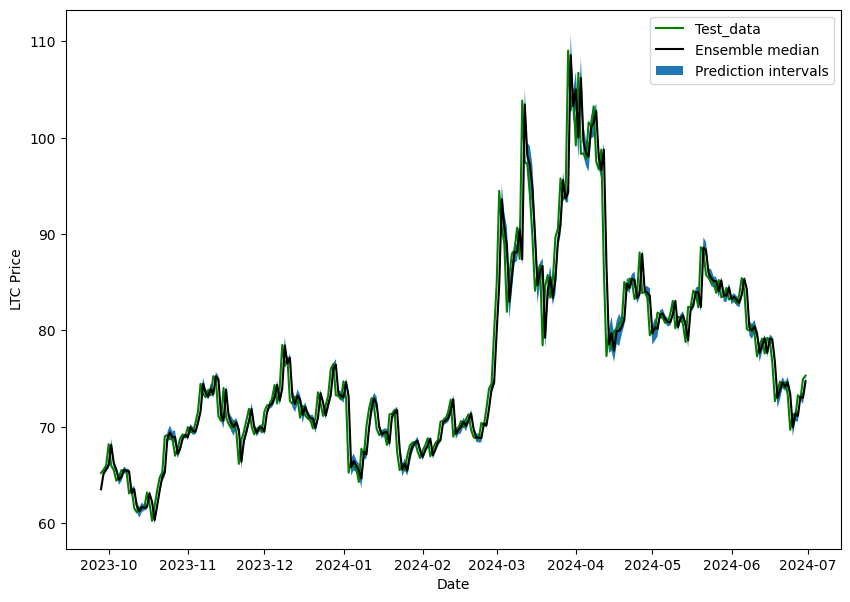

In [142]:
# Plot the median of our ensemble preds along with the prediction intervals
offset=200
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test_data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble median")
plt.xlabel("Date")
plt.ylabel("LTC Price")
plt.fill_between(X_test.index[offset:],
                (lower)[offset:],
                (upper)[offset:], label="Prediction intervals")
plt.legend();

Hmm.. 

So far all of our models predictions have been lagging behind the test data..

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data of from a normal distibution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in ML seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (What is possible for model to learn?)
2. What doesn't my model know? (What can a model never predict?)

There are two major types of uncertainty in ML you should know about:
* **Aleatoric unertainty** - cannot be reduced, often reffered as "data" uncertainty or "subway" unertainty
* **Epistemic uncertainty** - can be reduced, often reffered to as "model" or "coconut" uncertainty

### Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models predicted on the test dataset however, this is only a pseudofuture.

Let's now build a model which is capable of prediction into the future!

In [143]:
ltc_prices_window.head()

,Close,Block,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2017-12-13,290.01,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-14,272.40,25,290.01,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-15,294.00,25,272.40,290.01,NaN,NaN,NaN,NaN,NaN
2017-12-16,293.97,25,294.00,272.40,290.01,NaN,NaN,NaN,NaN
2017-12-17,311.40,25,293.97,294.00,272.40,290.01,NaN,NaN,NaN


In [144]:
ltc_prices_window.tail()

,Close,Block,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2024-06-26,71.02,6.25,71.35,69.68,73.37,74.61,74.17,74.69,73.77
2024-06-27,73.28,6.25,71.02,71.35,69.68,73.37,74.61,74.17,74.69
2024-06-28,72.90,6.25,73.28,71.02,71.35,69.68,73.37,74.61,74.17
2024-06-29,74.95,6.25,72.90,73.28,71.02,71.35,69.68,73.37,74.61
2024-06-30,75.31,6.25,74.95,72.90,73.28,71.02,71.35,69.68,73.37


In [145]:
X_all = ltc_prices_window.dropna().drop(["Close", "Block"], axis=1).to_numpy()
y_all = ltc_prices_window.dropna()["Close"]

X_all.shape, y_all.shape

((2385, 7), (2385,))

In [146]:
BATCH_SIZE = 1024

In [147]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all   = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [148]:
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [246]:
from keras import layers, Model

tf.random.set_seed(42)
inputs = layers.Input((7))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1)(x)

model_9 = Model(inputs, outputs)

model_9.compile(optimizer="Adam", loss="mae",)

In [150]:
model_9.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_316 (Dense)           (None, 128)               1024      
                                                                 
 dense_317 (Dense)           (None, 128)               16512     
                                                                 
 dense_318 (Dense)           (None, 1)                 129       
                                                                 
Total params: 17665 (69.00 KB)
Trainable params: 17665 (69.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
model_9.fit(
    dataset_all,
    epochs=1000,
    verbose=0,
    validation_data=dataset_all,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=100, verbose=1),
              keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)]
)

In [152]:
p = model_9.predict([[66.27, 64.80, 64.44, 59.49, 59.17, 57.22, 51.22]])

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 16ms/step


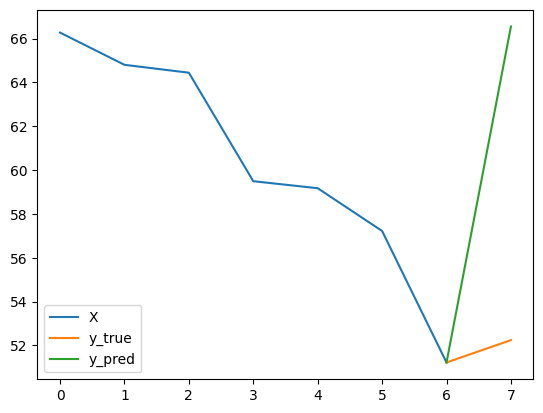

In [153]:
window__ = [66.27, 64.80, 64.44, 59.49, 59.17, 57.22, 51.22]
horizon__ = [52.24]
p = model_9.predict(tf.expand_dims(window__, axis=0))[0]

plt.plot(window__, label="X")
plt.plot([6, 7], [window__[-1]] + horizon__, label="y_true")
plt.plot([6, 7], [window__[-1]] + list(p), label="y_pred")
plt.legend();

In [154]:
evaluate_preds(y_all, make_preds(model_9, X_all))

75/75 [==============================] - 0s 650us/step


{'mae': 3.577697,
 'mse': 44.528458,
 'rmse': 6.6729646,
 'mape': 3.4917824,
 'mase': 0.98418695}

In [155]:
model_1_results

{'mae': 2.00239,
 'mse': 9.710378,
 'rmse': 3.1161478,
 'mape': 2.4424455,
 'mase': 1.0485909}

### Make preds on the future..

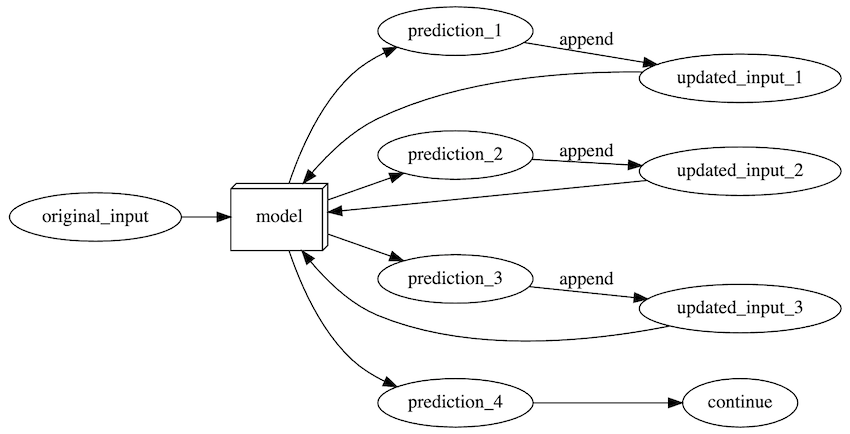

In [251]:
import numpy as np
import keras
INTO_FUTURE = 14
def make_preds_into_future(all_windows: np.ndarray, into_future: int, model: keras.Model) -> np.ndarray:
    forecasts = np.array([])
    # new_forecasts = np.append(new_forecasts, [[1, 2]])
    
    for _ in range(into_future):
        model.compile(optimizer="Adam", loss="mae")
        model.fit(
            dataset_all,
            epochs=100, 
            verbose=0,
            validation_data=dataset_all,
            callbacks=[keras.callbacks.ReduceLROnPlateau(), 
                       keras.callbacks.EarlyStopping(restore_best_weights=True, patience=15)]
        )
        new_price = model.predict(tf.expand_dims(all_windows[-1], axis=0), verbose=0)
        forecasts = np.append(forecasts, [new_price])
        all_windows = np.append(full_windows, np.expand_dims(np.append(full_windows[-1][1:], new_price), axis=0), axis=0)
    return forecasts

In [255]:
future_preds = make_preds_into_future(full_windows, 14, model_9)
future_preds

array([73.16490173, 69.88380432, 70.11428833, 69.71001434, 69.64217377,
       69.72609711, 69.64341736, 69.63518524, 69.68634033, 69.68628693,
       69.72472382, 69.72510529, 69.60743713, 69.68746948])

### Plot future forecasts

To plot our model's future forecasts against the historical data of LTC we're going to need a series of future dates (future dates from the final date of where our dataset ends).`

How about we create a function to return a date range from some specified start date to a specified number of days into the future (INTO_FUTURE).

To do so, we'll use a combination of NumPy's `datetime64` datatype as well as NumPy's `timedelta64` method which helps to create date ranges.

In [256]:
def get_future_dates(start_date, into_future: int, offset=1):
    """
    Returns array of datetime values from ranging from start_date to start_date+into_future.

    start_date: date to start range (np.datetime64)
    into_future: number of days to add onto start date for range (int)
    offset: number of days to offset start_date by (default 1)
    """
    dates = []
    for i in range(into_future):
        dates.append(start_date + np.timedelta64(i+offset, 'D'))
    return dates

In [257]:
INTO_FUTURE = 14
last_timestep = ltc_prices.index[-1]
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

[Timestamp('2024-07-01 00:00:00'),
 Timestamp('2024-07-02 00:00:00'),
 Timestamp('2024-07-03 00:00:00'),
 Timestamp('2024-07-04 00:00:00'),
 Timestamp('2024-07-05 00:00:00'),
 Timestamp('2024-07-06 00:00:00'),
 Timestamp('2024-07-07 00:00:00'),
 Timestamp('2024-07-08 00:00:00'),
 Timestamp('2024-07-09 00:00:00'),
 Timestamp('2024-07-10 00:00:00'),
 Timestamp('2024-07-11 00:00:00'),
 Timestamp('2024-07-12 00:00:00'),
 Timestamp('2024-07-13 00:00:00'),
 Timestamp('2024-07-14 00:00:00')]

In [272]:
real_future_prices = pd.read_csv("real_prices.csv", parse_dates=["Date"])
real_future_prices = real_future_prices[["Date", "Close"]][1:]
real_future_prices = real_future_prices.set_index(["Date"])
real_future_prices = real_future_prices.rename(columns={"Close": "real_price"})
real_future_prices.insert(1, "pred_price", future_preds, False)

In [273]:
real_future_prices

,real_price,pred_price
Date,,
2024-07-01,74.340248,73.164902
2024-07-02,75.863907,69.883804
2024-07-03,72.075050,70.114288
2024-07-04,65.315697,69.710014
2024-07-05,61.887257,69.642174
2024-07-06,65.430290,69.726097
2024-07-07,62.062256,69.643417
2024-07-08,64.869331,69.635185
2024-07-09,65.316864,69.686340


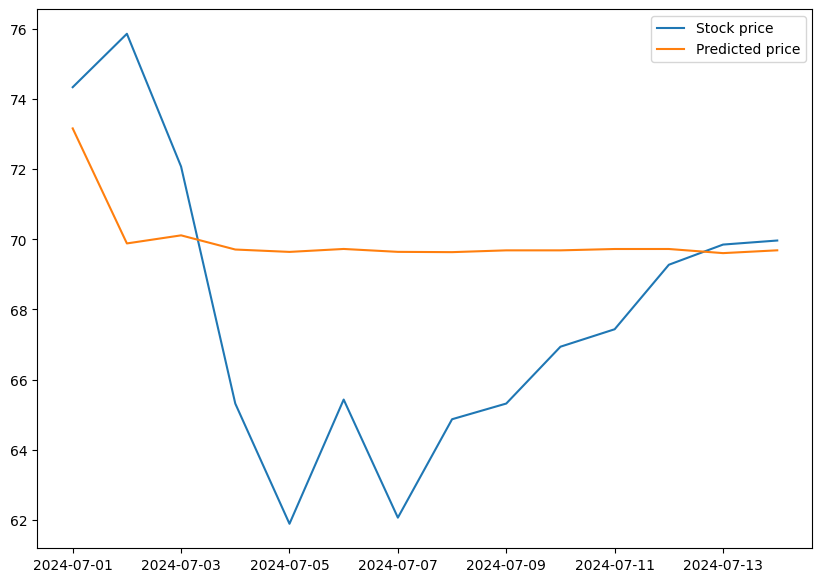

In [277]:
plt.figure(figsize=(10, 7))
plt.plot(real_future_prices.index, real_future_prices.real_price, label="Stock price")
plt.plot(real_future_prices.index, real_future_prices.pred_price, label="Predicted price")
plt.legend();


### Compare results

In [281]:
model_results = pd.DataFrame({"naive_model": naive_results,
                             "model_1_dense_w7_h1": model_1_results,
                             "model_2_dense_w30_h1": model_2_results,
                             "model_3_dense_w30_h7": model_3_results,
                             "model_4_CONV1D": model_4_results,
                             "model_5_LSTM": model_5_results,
                             "model_6_multivariate": model_6_1_results,
                             "model_7_NBeats": model_7_results,
                             "model_8_ensemble": ensemble_results}).T
model_results

,mae,mse,rmse,mape,mase
naive_model,1.920879,9.420247,3.069242,2.344156,1.000261
model_1_dense_w7_h1,2.002390,9.710378,3.116148,2.442446,1.048591
model_2_dense_w30_h1,2.326897,11.542919,3.397487,2.856201,1.232171
model_3_dense_w30_h7,3.830413,32.120148,4.405251,4.676385,2.011979
model_4_CONV1D,1.913621,9.443471,3.073023,2.341041,1.002105
model_5_LSTM,1.911146,9.470893,3.077482,2.332438,1.000809
model_6_multivariate,1.930524,9.505301,3.083067,2.355949,1.010957
model_7_NBeats,1.925089,9.558372,3.091662,2.353859,1.008111
model_8_ensemble,1.903677,9.346688,3.057235,2.324256,0.996898


<Axes: >

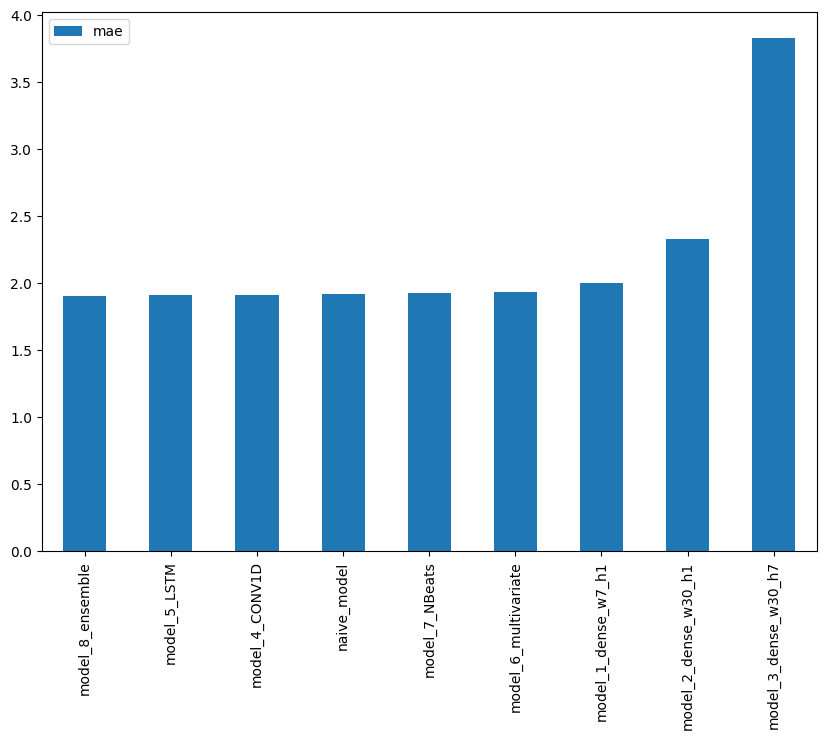

In [282]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")

# Exercises

## For most of our models we used WINDOW_SIZE=7, but is there a better window size?

In [313]:
choose_window_results = {}

for window_size in range(2, 31):
    full_windows, full_labels = make_windows(ltc_df["Close"].to_numpy(), window_size=window_size)
    
    choose_input = keras.layers.Input((window_size))
    x = keras.layers.Dense(128, activation="relu")(choose_input)
    x = keras.layers.Dense(128, activation="relu")(x)
    choose_output = keras.layers.Dense(1)(x)

    choose_window_model = keras.Model(choose_input, choose_output)
    
    choose_window_model.compile(optimizer="Adam", loss="mae")
    print(choose_window_model.input_shape)
    choose_window_model.fit(
        full_windows, full_labels,
        epochs=100,
        verbose=0,
        validation_data=(full_windows, full_labels),
        callbacks=[keras.callbacks.EarlyStopping(patience=200,restore_best_weights=True),
                   keras.callbacks.ReduceLROnPlateau(patience=100, verbose=1)]
    )

    preds = make_preds(choose_window_model, full_windows)
    results = evaluate_preds(full_labels, preds)
    choose_window_results[f"window_size_{window_size}"] = results
    print(f"Window size: {window_size}\n Results: {results}\n--------")
choose_window_results    

(None, 2)
75/75 [==============================] - 0s 924us/step
Window size: 2
 Results: {'mae': 57.722065, 'mse': 6331.0103, 'rmse': 74.7854, 'mape': 69.84408, 'mase': 15.71733}
--------
(None, 3)
75/75 [==============================] - 0s 2ms/step
Window size: 3
 Results: {'mae': 56.92106, 'mse': 6154.462, 'rmse': 73.2754, 'mape': 68.03065, 'mase': 15.4927845}
--------
(None, 4)
75/75 [==============================] - 0s 899us/step
Window size: 4
 Results: {'mae': 56.84008, 'mse': 6132.9727, 'rmse': 73.18783, 'mape': 68.051605, 'mase': 15.495048}
--------
(None, 5)
75/75 [==============================] - 0s 1ms/step
Window size: 5
 Results: {'mae': 56.821407, 'mse': 6122.0635, 'rmse': 73.218956, 'mape': 68.237335, 'mase': 15.555598}
--------
(None, 6)
75/75 [==============================] - 0s 899us/step
Window size: 6
 Results: {'mae': 58.015434, 'mse': 6369.76, 'rmse': 75.55533, 'mape': 71.36157, 'mase': 15.900482}
--------
(None, 7)
75/75 [==============================] - 0s

{'window_size_2': {'mae': 57.722065,
  'mse': 6331.0103,
  'rmse': 74.7854,
  'mape': 69.84408,
  'mase': 15.71733},
 'window_size_3': {'mae': 56.92106,
  'mse': 6154.462,
  'rmse': 73.2754,
  'mape': 68.03065,
  'mase': 15.4927845},
 'window_size_4': {'mae': 56.84008,
  'mse': 6132.9727,
  'rmse': 73.18783,
  'mape': 68.051605,
  'mase': 15.495048},
 'window_size_5': {'mae': 56.821407,
  'mse': 6122.0635,
  'rmse': 73.218956,
  'mape': 68.237335,
  'mase': 15.555598},
 'window_size_6': {'mae': 58.015434,
  'mse': 6369.76,
  'rmse': 75.55533,
  'mape': 71.36157,
  'mase': 15.900482},
 'window_size_7': {'mae': 57.090054,
  'mse': 6153.83,
  'rmse': 73.85235,
  'mape': 69.40741,
  'mase': 15.704875},
 'window_size_8': {'mae': 57.66723,
  'mse': 6268.747,
  'rmse': 74.95998,
  'mape': 71.02559,
  'mase': 15.858277},
 'window_size_9': {'mae': 57.321266,
  'mse': 6185.6665,
  'rmse': 74.33888,
  'mape': 70.353905,
  'mase': 15.849821},
 'window_size_10': {'mae': 56.576405,
  'mse': 6026.082

In [314]:
list(tf.keras.preprocessing.timeseries_dataset_from_array(tf.squeeze(ltc_prices), sequence_length=7, targets=None, batch_size=1024))

[<tf.Tensor: shape=(1024, 7), dtype=float64, numpy=
 array([[290.01, 272.4 , 294.  , ..., 311.4 , 352.  , 338.48],
        [272.4 , 294.  , 293.97, ..., 352.  , 338.48, 302.7 ],
        [294.  , 293.97, 311.4 , ..., 338.48, 302.7 , 302.  ],
        ...,
        [ 45.69,  46.24,  46.25, ...,  45.51,  46.69,  46.34],
        [ 46.24,  46.25,  44.88, ...,  46.69,  46.34,  45.99],
        [ 46.25,  44.88,  45.51, ...,  46.34,  45.99,  46.55]])>,
 <tf.Tensor: shape=(1024, 7), dtype=float64, numpy=
 array([[44.88, 45.51, 46.69, ..., 45.99, 46.55, 47.21],
        [45.51, 46.69, 46.34, ..., 46.55, 47.21, 47.78],
        [46.69, 46.34, 45.99, ..., 47.21, 47.78, 48.88],
        ...,
        [92.37, 94.09, 92.09, ..., 89.14, 89.45, 90.64],
        [94.09, 92.09, 93.16, ..., 89.45, 90.64, 90.6 ],
        [92.09, 93.16, 89.14, ..., 90.64, 90.6 , 91.44]])>,
 <tf.Tensor: shape=(338, 7), dtype=float64, numpy=
 array([[93.16, 89.14, 89.45, ..., 90.6 , 91.44, 94.32],
        [89.14, 89.45, 90.64, ..., 9

<Axes: >

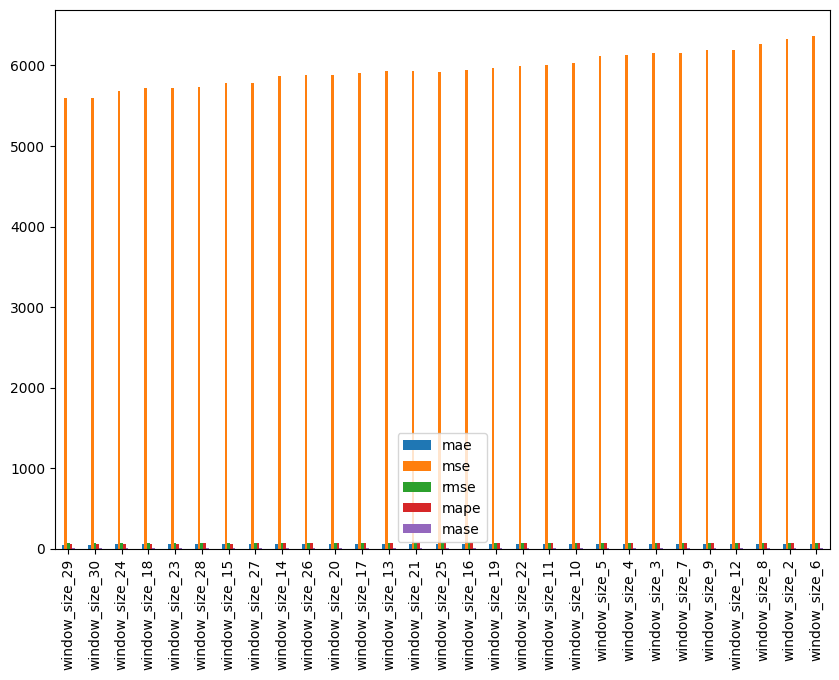

In [315]:
pd.DataFrame(choose_window_results).T.sort_values(by="mae").plot(figsize=(10, 7), kind="bar")